<a href="https://colab.research.google.com/github/yumi-h-1/NLP/blob/main/Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intent Classification for Bank Customer Queries



## Import the dataset 'banking77'

In [1]:
# Mount the drive to save and load files and models
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Install datasets from huggingface
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 12.4 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [ ]:
# Import libraries
import datasets
from datasets import load_dataset
import numpy as np
import matplotlib.pyplot as plt
import re
import string
import nltk
from nltk.corpus import stopwords
from pprint import pprint
from collections import Counter
from sklearn.metrics import precision_score, recall_score, f1_score

In [ ]:
# Take the dataset 'banking77'
banking77 = load_dataset('banking77')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/10003 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3080 [00:00<?, ? examples/s]

In [ ]:
# Check its structure
banking77

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 10003
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 3080
    })
})

In [ ]:
# Check the data format of the dataset
banking77.cache_files

# Arrow type

{'train': [{'filename': '/root/.cache/huggingface/datasets/banking77/default/0.0.0/f54121560de48f2852f90be299010d1d6dc612ec/banking77-train.arrow'}],
 'test': [{'filename': '/root/.cache/huggingface/datasets/banking77/default/0.0.0/f54121560de48f2852f90be299010d1d6dc612ec/banking77-test.arrow'}]}

## Data Preprocessing: Remove numbers, punctuations, double white spaces and apply lowercase

In [ ]:
# Define the function to remove numbers
def remove_num(example):
    return {'text': re.sub(r'\d+', '', example['text'])}

In [ ]:
# Mapping the lowercase function
banking77_wonum = banking77.map(remove_num)

Map:   0%|          | 0/10003 [00:00<?, ? examples/s]

Map:   0%|          | 0/3080 [00:00<?, ? examples/s]

In [ ]:
# Apply lowercase to all texts in the dataset
# Define the function
def lowercase(example):
  return {'text': example['text'].lower()}

In [ ]:
# Mapping the lowercase function
banking77_lowercase = banking77_wonum.map(lowercase)

Map:   0%|          | 0/10003 [00:00<?, ? examples/s]

Map:   0%|          | 0/3080 [00:00<?, ? examples/s]

In [ ]:
# Remove punctuations in the dataset
# Check the punctuation
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
# Define the removing puctuations function
def remove_punctuations(example):
  return {'text': example['text'].translate(str.maketrans('', '', string.punctuation))}

In [ ]:
# Mapping the function
banking77_wopunc = banking77_lowercase.map(remove_punctuations)

Map:   0%|          | 0/10003 [00:00<?, ? examples/s]

Map:   0%|          | 0/3080 [00:00<?, ? examples/s]

In [ ]:
# Define the removing double white spaces function
def remove_doublespaces(example):
  return {'text': re.sub('\s+', ' ', example['text']).strip()}

In [ ]:
# Mapping the function
banking77_wods = banking77_wopunc.map(remove_doublespaces)

Map:   0%|          | 0/10003 [00:00<?, ? examples/s]

Map:   0%|          | 0/3080 [00:00<?, ? examples/s]

In [ ]:
# Take stopwords in English version
nltk.download('stopwords')
eng_stop = set(stopwords.words("english"))

# Define the removing double white spaces function
def remove_stopwords(example):
    words = example['text'].split()  # Split the text into words
    filtered_words = [word for word in words if word.lower() not in eng_stop]  # Remove stopwords
    return {'text': ' '.join(filtered_words)}  # Join the filtered words back into a single string

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Mapping the function
banking77_preprocessed = banking77_wods.map(remove_stopwords)

Map:   0%|          | 0/10003 [00:00<?, ? examples/s]

Map:   0%|          | 0/3080 [00:00<?, ? examples/s]

In [ ]:
# Extract training set and test set
trainset = banking77_preprocessed['train']
testset = banking77_preprocessed['test']

In [ ]:
# Check columns in the traininig set
trainset.column_names

['text', 'label']

In [ ]:
# Check the featrues in training set
print(trainset.features)

{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['activate_my_card', 'age_limit', 'apple_pay_or_google_pay', 'atm_support', 'automatic_top_up', 'balance_not_updated_after_bank_transfer', 'balance_not_updated_after_cheque_or_cash_deposit', 'beneficiary_not_allowed', 'cancel_transfer', 'card_about_to_expire', 'card_acceptance', 'card_arrival', 'card_delivery_estimate', 'card_linking', 'card_not_working', 'card_payment_fee_charged', 'card_payment_not_recognised', 'card_payment_wrong_exchange_rate', 'card_swallowed', 'cash_withdrawal_charge', 'cash_withdrawal_not_recognised', 'change_pin', 'compromised_card', 'contactless_not_working', 'country_support', 'declined_card_payment', 'declined_cash_withdrawal', 'declined_transfer', 'direct_debit_payment_not_recognised', 'disposable_card_limits', 'edit_personal_details', 'exchange_charge', 'exchange_rate', 'exchange_via_app', 'extra_charge_on_statement', 'failed_transfer', 'fiat_currency_support', 'get_disposable_virtual_card'

In [ ]:
# Check the first five elements in the training set
pprint(trainset[:5], sort_dicts=False)
pprint(testset[:5], sort_dicts=False)

{'text': ['still waiting card',
          'card still hasnt arrived weeks',
          'waiting week card still coming',
          'track card process delivery',
          'know get card lost'],
 'label': [11, 11, 11, 11, 11]}
{'text': ['locate card',
          'still received new card ordered week ago',
          'ordered card arrived help please',
          'way know card arrive',
          'card arrived yet'],
 'label': [11, 11, 11, 11, 11]}


All preprocessing steps have been applied.

In [ ]:
# Describe general information of the training set
pprint(trainset.info)

DatasetInfo(description='',
            citation='',
            homepage='',
            license='',
            features={'label': ClassLabel(names=['activate_my_card',
                                                 'age_limit',
                                                 'apple_pay_or_google_pay',
                                                 'atm_support',
                                                 'automatic_top_up',
                                                 'balance_not_updated_after_bank_transfer',
                                                 'balance_not_updated_after_cheque_or_cash_deposit',
                                                 'beneficiary_not_allowed',
                                                 'cancel_transfer',
                                                 'card_about_to_expire',
                                                 'card_acceptance',
                                                 'card_arrival',
               

In [ ]:
# Change the format as dataframe
banking77_preprocessed.set_format(type='pandas')

In [ ]:
# Define a dataframe for the training set
train_df = banking77_preprocessed['train'][:]

In [ ]:
# Check the dataframe of the training set
train_df

,text,label
0,still waiting card,11
1,card still hasnt arrived weeks,11
2,waiting week card still coming,11
3,track card process delivery,11
4,know get card lost,11
...,...,...
9998,provide support countries,24
9999,countries supporting,24
10000,countries getting support,24
10001,cards available eu,24


In [ ]:
# Check if there is null data
train_df.isnull().sum()

text     0
label    0
dtype: int64

In [ ]:
train_df

,text,label
0,still waiting card,11
1,card still hasnt arrived weeks,11
2,waiting week card still coming,11
3,track card process delivery,11
4,know get card lost,11
...,...,...
9998,provide support countries,24
9999,countries supporting,24
10000,countries getting support,24
10001,cards available eu,24


In [ ]:
# Check if there is the same text after text preprocessing
# Group by text and label, then count occurrences
train_df['count'] = train_df.groupby(['text', 'label'])['text'].transform('count')

# Filter rows where count > 1 (duplicates)
duplicates_df = train_df[train_df['count'] > 1]

# Sort it by text to group duplicates together
duplicates_df = duplicates_df.sort_values(by='text')

In [ ]:
duplicates_df[['text', 'label']]

,text,label
5028,able get cash atm,26
5011,able get cash atm,26
4178,able get visa mastercard,73
4135,able get visa mastercard,73
5796,able see refund,51
...,...,...
5460,would like cancel purchase,52
31,would like track card sent,11
98,would like track card sent,11
4949,wouldnt atm give money,26


In [ ]:
# Remove duplicates based on text, keeping the first one
train_df = train_df.drop_duplicates(subset='text', keep='first')

In [ ]:
train_df

,text,label,count
0,still waiting card,11,2
1,card still hasnt arrived weeks,11,1
2,waiting week card still coming,11,1
3,track card process delivery,11,1
4,know get card lost,11,1
...,...,...,...
9997,moved us get card,24,1
9998,provide support countries,24,1
9999,countries supporting,24,1
10000,countries getting support,24,1


The average is 36.17641293694871. The median is 29.0. The max length is 303.


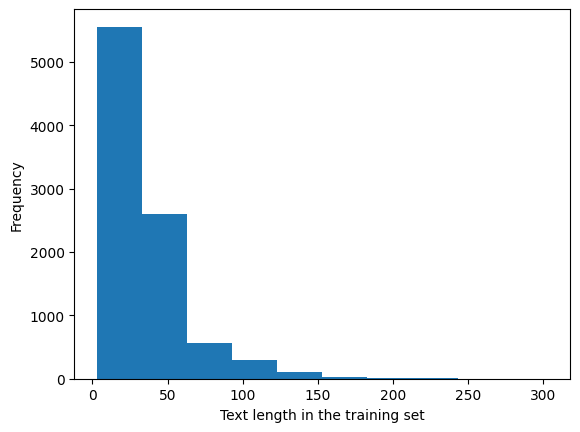

In [ ]:
# Check the text length in the training set
lengths = np.array([len(text) for text in train_df['text']])
print(f'The average is {np.mean(lengths)}. The median is {np.median(lengths)}. The max length is {np.max(lengths)}.')

# Plot the histogram
plt.hist(lengths)
plt.xlabel('Text length in the training set')
plt.ylabel('Frequency')
plt.show()

Since the median is 29, a length of 29 will be used.
The rest will be cut or filled in with padding.

In [ ]:
# Define a dataframe for the test set
test_df = banking77_preprocessed['test'][:]

In [ ]:
# Check the dataframe of the test set
test_df

,text,label
0,locate card,11
1,still received new card ordered week ago,11
2,ordered card arrived help please,11
3,way know card arrive,11
4,card arrived yet,11
...,...,...
3075,im uk still get card,24
3076,many countries support,24
3077,countries business,24
3078,countries operate,24


In [ ]:
# Check if there is null data
test_df.isnull().sum()

text     0
label    0
dtype: int64

In [ ]:
# Check the data type of elements in the dataframes
print(train_df['text'].dtype)
print(test_df['text'].dtype)
print(train_df['label'].dtype)
print(test_df['label'].dtype)

object
object
int64
int64


In [ ]:
# Check the number of labels in the training set
train_df['label'].nunique()

77

In [ ]:
# Check the balance of labels in the training set
train_df['label'].value_counts()

label
6     181
28    178
75    178
15    176
66    168
     ... 
41     69
18     56
10     48
72     38
23     33
Name: count, Length: 77, dtype: int64

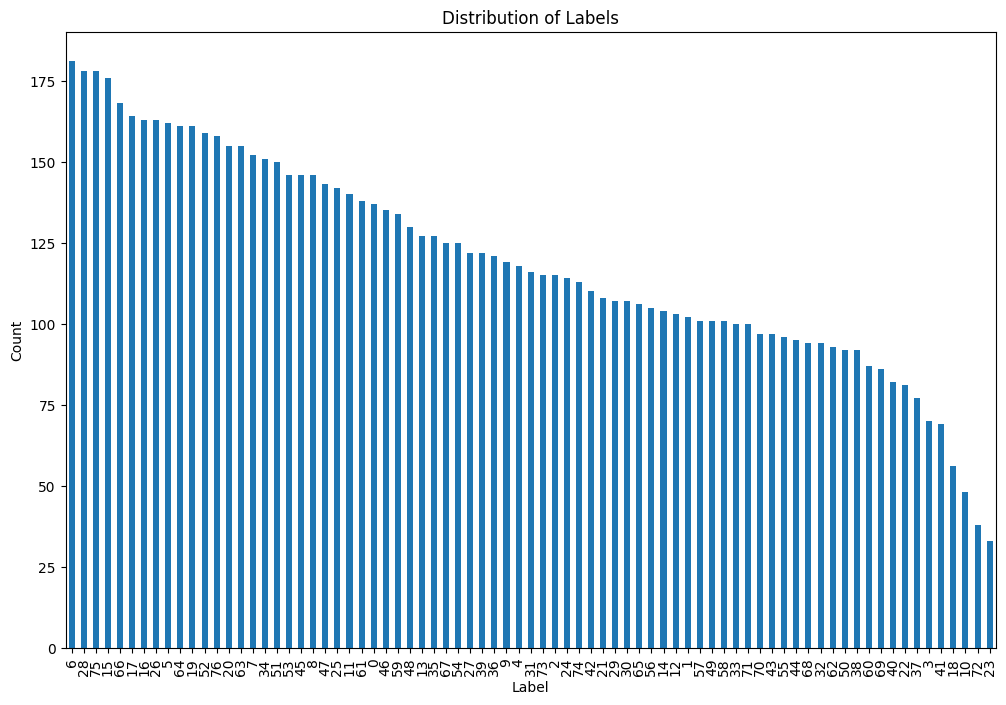

In [ ]:
# Plot histogram for labels in the training set
plt.figure(figsize=(12, 8))
train_df['label'].value_counts().plot(kind='bar')
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Labels')
plt.xticks(rotation=90)
plt.show()

The class in the training set is imbalanced.

In [ ]:
# Check the number of labels in the test set
test_df['label'].nunique()

77

In [ ]:
# Check the balance of labels in the test set
test_df['label'].value_counts()

label
11    40
63    40
50    40
64    40
7     40
      ..
61    40
10    40
40    40
54    40
24    40
Name: count, Length: 77, dtype: int64

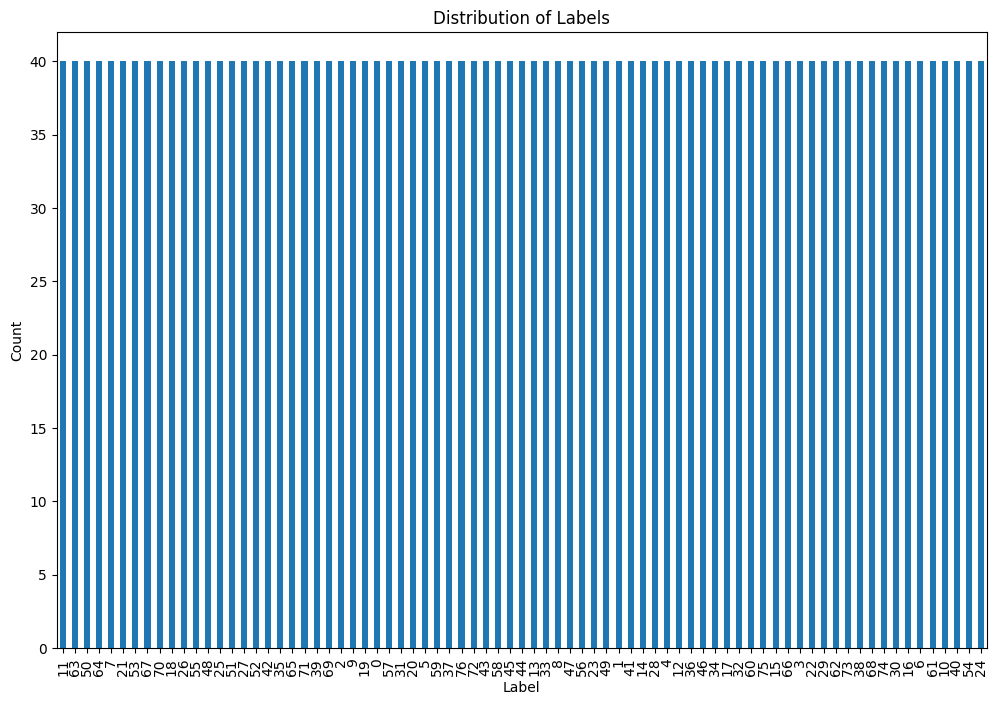

In [ ]:
# Plot histogram for labels in the test set
plt.figure(figsize=(12, 8))
test_df['label'].value_counts().plot(kind='bar')
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Labels')
plt.xticks(rotation=90)
plt.show()

The class in the test set is balanced.

## Tokenize the text in the dataset

### For LSTM Model

In [ ]:
# Seperate the training set to a training set and a validation set
# Import the library
from sklearn.model_selection import train_test_split

# Split the data to X and y
X = train_df['text']
y = train_df['label']

# Split the training set (80% for the training set, 20% for the validation set)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=train_df['label']) # Balance the class

In [ ]:
# Reset the index
X_train.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)

In [ ]:
# Define X_test and y_test from the test set
X_test = test_df['text']
y_test = test_df['label']

In [ ]:
# Count the words to find the vocabulary size in the training set
# Define the function to cumulate the number of words
def count_word(X_train):
    count = Counter()
    for text in X_train.values:
        for word in text.split():
            count[word] += 1
    return count

# Count the number of words
word_counts = count_word(X_train)

print(f'The vocabulary size in the training set is {len(word_counts)}')

The vocabulary size in the training set is 2088


In [ ]:
# Check the inside of the vocabulary
word_counts

Counter({'transaction': 256,
         'reverted': 49,
         'card': 1942,
         'charged': 401,
         'payment': 551,
         'made': 285,
         'cash': 518,
         'withdrawal': 212,
         'atm': 353,
         'listed': 12,
         'dont': 259,
         'remember': 28,
         'making': 40,
         'unauthorized': 11,
         'direct': 76,
         'debit': 106,
         'account': 1059,
         'please': 394,
         'explain': 61,
         'fee': 333,
         'transfer': 807,
         'verify': 95,
         'new': 256,
         'tried': 199,
         'sending': 13,
         'standard': 9,
         'five': 5,
         'times': 102,
         'hasnt': 134,
         'gone': 66,
         'problem': 69,
         'get': 606,
         'refund': 213,
         'purchase': 112,
         'cost': 57,
         'time': 122,
         'frame': 9,
         'getting': 122,
         'identity': 152,
         'verification': 85,
         'isnt': 130,
         'working': 145,
   

In [ ]:
# Check the most frequent words
word_counts.most_common(5)

[('card', 1942),
 ('account', 1059),
 ('money', 895),
 ('transfer', 807),
 ('get', 606)]

In [ ]:
# Store the size of the vocabulary
voca_size = len(word_counts)
print(voca_size)

2088


In [ ]:
# Change the X data to arrays
X_train_array = X_train.to_numpy()
X_val_array = X_val.to_numpy()
X_test_array = X_test.to_numpy()

In [ ]:
# Change the y data to arrays
y_train_array = y_train.to_numpy()
y_val_array = y_val.to_numpy()
y_test_array = y_test.to_numpy()

In [ ]:
# Check the dimension of the variables
print(X_train_array.shape)
print(X_val_array.shape)
print(X_test_array.shape)
print(y_train_array.shape)
print(y_val_array.shape)
print(y_test_array.shape)

(7346,)
(1837,)
(3080,)
(7346,)
(1837,)
(3080,)


In [ ]:
# Check the type of the variables
print(X_train_array.__class__)
print(X_val_array.__class__)
print(X_test_array.__class__)
print(y_train_array.__class__)
print(y_val_array.__class__)
print(y_test_array.__class__)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [ ]:
# Import tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer

# Define the tokenizer with vocabulary size of the training data
tokenizer = Tokenizer(num_words=voca_size)
# Fit the tokenizer with X train
tokenizer.fit_on_texts(X_train_array)

In [ ]:
# Define the word index
word_index = tokenizer.word_index
word_index

{'card': 1,
 'account': 2,
 'money': 3,
 'transfer': 4,
 'get': 5,
 'payment': 6,
 'need': 7,
 'cash': 8,
 'top': 9,
 'exchange': 10,
 'charged': 11,
 'please': 12,
 'app': 13,
 'atm': 14,
 'fee': 15,
 'use': 16,
 'pending': 17,
 'made': 18,
 'topup': 19,
 'help': 20,
 'long': 21,
 'would': 22,
 'still': 23,
 'take': 24,
 'dont': 25,
 'didnt': 26,
 'rate': 27,
 'transaction': 28,
 'new': 29,
 'make': 30,
 'wrong': 31,
 'pin': 32,
 'charge': 33,
 'know': 34,
 'im': 35,
 'see': 36,
 'like': 37,
 'cards': 38,
 'refund': 39,
 'want': 40,
 'withdrawal': 41,
 'declined': 42,
 'one': 43,
 'extra': 44,
 'yet': 45,
 'tried': 46,
 'go': 47,
 'got': 48,
 'tell': 49,
 'received': 50,
 'cant': 51,
 'using': 52,
 'work': 53,
 'something': 54,
 'amount': 55,
 'virtual': 56,
 'showing': 57,
 'currency': 58,
 'going': 59,
 'statement': 60,
 'identity': 61,
 'change': 62,
 'disposable': 63,
 'currencies': 64,
 'working': 65,
 'bank': 66,
 'whats': 67,
 'funds': 68,
 'ago': 69,
 'back': 70,
 'check': 71,

In [ ]:
# Define the maximum length as 29 (the median length of the training set)
max_length_train_text = 29
max_length_train_text

29

In [ ]:
# Encode the text data
X_train_sequences = tokenizer.texts_to_sequences(X_train_array)
X_val_sequences = tokenizer.texts_to_sequences(X_val_array)
X_test_sequences = tokenizer.texts_to_sequences(X_test_array)

In [ ]:
# Add padding to the encoded data
# Import pad_sequesnces
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Padding and truncation will be added to post-texts
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_length_train_text, padding="post", truncating="post")
X_val_padded = pad_sequences(X_val_sequences, maxlen=max_length_train_text, padding="post", truncating="post")
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_length_train_text, padding="post", truncating="post")

In [ ]:
# Check the dimension of the variables
print(X_train_padded.shape)
print(X_val_padded.shape)
print(X_test_padded.shape)

(7346, 29)
(1837, 29)
(3080, 29)


In [ ]:
# Check the first 3 elements of all X train variables
print(X_train_array[3])
print(X_train_sequences[3])
print(X_train_padded[3])

unauthorized direct debit account
[493, 113, 85, 2]
[493 113  85   2   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0]


In [ ]:
# Define the folder path to save the test files
folder_path = '/content/drive/MyDrive/Datasets/Banking77/'

# Define the file path
Xtest_path = folder_path + 'X_test_padded.npy'
ytest_path = folder_path + 'y_test_array.npy'

# Save the test set
np.save(Xtest_path, X_test_padded)
np.save(ytest_path, y_test_array)

## LSTM (with a word embedding layer)

### LSTM (baseline)

In [ ]:
# Import tensorflow and fix the random seed
import tensorflow as tf
tf.random.set_seed(42)

In [ ]:
# Import keras from tensorflow and layers to build LSTM models
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
# Define the output dimension for the embedding layer and hidden units
embedding_output_dim = 100 # Random number
hidden_unit = 30 # Random number
nlabel = 77 # number of classes

# Build the baseline model
model = keras.models.Sequential()
model.add(layers.Embedding(voca_size, embedding_output_dim))
model.add(layers.LSTM(hidden_unit))
model.add(layers.Dense(nlabel, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Summary the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         208800    
                                                                 
 lstm (LSTM)                 (None, 30)                15720     
                                                                 
 dense (Dense)               (None, 77)                2387      
                                                                 
Total params: 226907 (886.36 KB)
Trainable params: 226907 (886.36 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Define the folder path to save the model
folder_path = '/content/drive/MyDrive/Colab Notebooks/Classifying Bank Customer Service Questions/models/LSTM/'

# Define the file path for the model checkpoint
model_checkpoint_path = folder_path + 'LSTM_embedding_model.keras'

# Define the model checkpoint
mc = tf.keras.callbacks.ModelCheckpoint(
    filepath=model_checkpoint_path,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
# Define early stopping
es =  tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3) # Random number of patience

In [ ]:
# Import time to measure the elapsed time
import time

# Measure time before training
start_time = time.time()

# Fit the model
history = model.fit(
    X_train_padded, y_train,
    epochs = 100, # Random number
    validation_data = (X_val_padded, y_val),
    callbacks = [mc, es],
    batch_size = 32) # Random number

# End the training time
end_time = time.time()

# Measure the training time
training_time = end_time - start_time
print("Total training time:", training_time, "seconds")

Epoch 1/100
230/230 [==============================] - 11s 30ms/step - loss: 4.2625 - accuracy: 0.0199 - val_loss: 4.0341 - val_accuracy: 0.0338
Epoch 2/100
230/230 [==============================] - 5s 24ms/step - loss: 3.9935 - accuracy: 0.0317 - val_loss: 3.9296 - val_accuracy: 0.0343
Epoch 3/100
230/230 [==============================] - 7s 31ms/step - loss: 3.9381 - accuracy: 0.0381 - val_loss: 3.8548 - val_accuracy: 0.0495
Epoch 4/100
230/230 [==============================] - 5s 23ms/step - loss: 3.7424 - accuracy: 0.0555 - val_loss: 3.6219 - val_accuracy: 0.0719
Epoch 5/100
230/230 [==============================] - 6s 26ms/step - loss: 3.4658 - accuracy: 0.0826 - val_loss: 3.3864 - val_accuracy: 0.1018
Epoch 6/100
230/230 [==============================] - 7s 29ms/step - loss: 3.1828 - accuracy: 0.1248 - val_loss: 3.1310 - val_accuracy: 0.1671
Epoch 7/100
230/230 [==============================] - 6s 24ms/step - loss: 2.9293 - accuracy: 0.1561 - val_loss: 2.9261 - val_accuracy

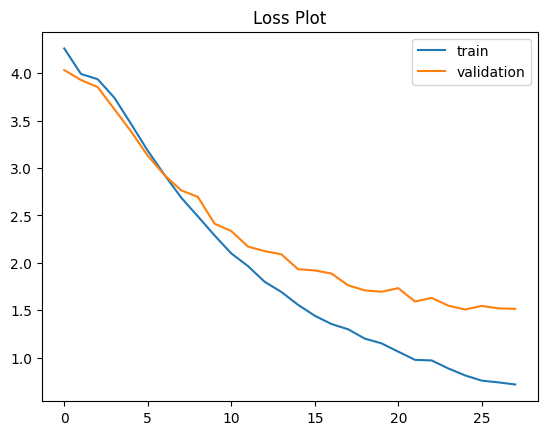

In [ ]:
# Plot the loss
plt.title('Loss Plot')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

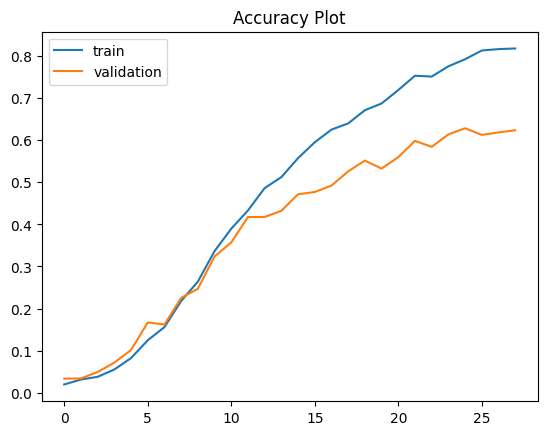

In [ ]:
# Plot the accuracy
plt.title('Accuracy Plot')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.show()

In [ ]:
# Load the saved model
saved_model = tf.keras.models.load_model(model_checkpoint_path)

# Evaluate the model with the test set
loss, accuracy = saved_model.evaluate(X_test_padded, y_test_array)

print("Test Loss:", loss)
print("Test Accuracy:", round((accuracy*100), 2))

97/97 [==============================] - 2s 10ms/step - loss: 1.4729 - accuracy: 0.6429
Test Loss: 1.472944736480713
Test Accuracy: 64.29


In [ ]:
# Import the library to check precision, recall, and F1 score
from sklearn.metrics import precision_score, recall_score, f1_score

# Check predictions with the test set
y_test_prob = saved_model.predict(X_test_padded)

# Convert probabilities to class labels
y_test_pred = np.argmax(y_test_prob, axis=1)

# Calculate precision, recall, and f1 score
precision = precision_score(y_test_array, y_test_pred, average='weighted')
recall = recall_score(y_test_array, y_test_pred, average='weighted')
f1 = f1_score(y_test_array, y_test_pred, average='weighted')

print("Precision:", round((precision*100), 2))
print("Recall:", round((recall*100), 2))
print("F1 Score:", round((f1*100), 2))

97/97 [==============================] - 2s 8ms/step
Precision: 66.22
Recall: 64.29
F1 Score: 62.87


In [ ]:
# Error analysis
# Import the library for classification report
from sklearn.metrics import classification_report

# Print classification report
print(classification_report(y_test_array, y_test_pred))

# Check misclassified data
misclassified_data = np.where(y_test_pred != y_test_array)[0]
print(f"The number of misclassifications: {len(misclassified_data)}")

# Check the ratio of misclassifications
misclassification_ratio = (len(misclassified_data) / len(y_test_array)) * 100
# Round the number
rounded_ratio = round(misclassification_ratio, 2)
print(f"Proportion of misclassifications: {rounded_ratio}%")

# Iterate over misclassified data for error analysis
for idx in misclassified_data[:30]:
    input_text = X_test[idx]
    true_label = y_test[idx]
    predicted_label = y_test_pred[idx]

    # Print information about the misclassified data
    print("Input Text:", input_text)
    print("Actual Label:", true_label)
    print("Predicted Label:", predicted_label)
    print()

              precision    recall  f1-score   support

           0       0.79      0.85      0.82        40
           1       0.91      0.78      0.84        40
           2       0.93      0.97      0.95        40
           3       0.68      0.68      0.68        40
           4       0.97      0.72      0.83        40
           5       0.37      0.50      0.43        40
           6       0.57      0.60      0.59        40
           7       0.80      0.70      0.75        40
           8       0.79      0.68      0.73        40
           9       0.93      0.95      0.94        40
          10       0.77      0.25      0.38        40
          11       0.71      0.55      0.62        40
          12       0.65      0.65      0.65        40
          13       0.62      0.85      0.72        40
          14       0.59      0.60      0.59        40
          15       0.54      0.70      0.61        40
          16       0.35      0.28      0.31        40
          17       0.87    

### LSTM (with dropout)

In [ ]:
# Define the output dimension for the embedding layer and hidden units
embedding_output_dim = 100 # Random number
hidden_unit = 30 # Random number
nlabel = 77 # number of classes

# Build the baseline model
dropout_model = keras.models.Sequential()
dropout_model.add(layers.Embedding(voca_size, embedding_output_dim))
dropout_model.add(layers.LSTM(hidden_unit, dropout=0.2)) # Random number
dropout_model.add(layers.Dense(nlabel, activation='softmax'))

# Compile the model
dropout_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Summary the model
dropout_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 100)         208800    
                                                                 
 lstm_1 (LSTM)               (None, 30)                15720     
                                                                 
 dense_1 (Dense)             (None, 77)                2387      
                                                                 
Total params: 226907 (886.36 KB)
Trainable params: 226907 (886.36 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Define the folder path to save the model
folder_path = '/content/drive/MyDrive/Colab Notebooks/Classifying Bank Customer Service Questions/models/LSTM/'

# Define the file path for the model checkpoint
model_checkpoint_path = folder_path + 'dropout_LSTM_embedding_model.keras'

# Define the model checkpoint
mc = tf.keras.callbacks.ModelCheckpoint(
    filepath=model_checkpoint_path,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
# Import time to measure the elapsed time
import time

# Measure time before training
start_time = time.time()

# Fit the model
history = dropout_model.fit(
    X_train_padded, y_train,
    epochs = 100, # Random number
    validation_data = (X_val_padded, y_val),
    callbacks = [mc, es],
    batch_size = 32)

# End the training time
end_time = time.time()

# Measure the training time
training_time = end_time - start_time
print("Total training time:", training_time, "seconds")

Epoch 1/100
230/230 [==============================] - 10s 29ms/step - loss: 4.2711 - accuracy: 0.0182 - val_loss: 4.0823 - val_accuracy: 0.0338
Epoch 2/100
230/230 [==============================] - 7s 30ms/step - loss: 4.0866 - accuracy: 0.0283 - val_loss: 4.1577 - val_accuracy: 0.0278
Epoch 3/100
230/230 [==============================] - 8s 34ms/step - loss: 4.0583 - accuracy: 0.0252 - val_loss: 4.0054 - val_accuracy: 0.0327
Epoch 4/100
230/230 [==============================] - 11s 47ms/step - loss: 3.9583 - accuracy: 0.0294 - val_loss: 3.8965 - val_accuracy: 0.0463
Epoch 5/100
230/230 [==============================] - 9s 38ms/step - loss: 3.8102 - accuracy: 0.0438 - val_loss: 3.7361 - val_accuracy: 0.0550
Epoch 6/100
230/230 [==============================] - 7s 31ms/step - loss: 3.6619 - accuracy: 0.0636 - val_loss: 3.6422 - val_accuracy: 0.0659
Epoch 7/100
230/230 [==============================] - 8s 33ms/step - loss: 3.5815 - accuracy: 0.0679 - val_loss: 3.6077 - val_accurac

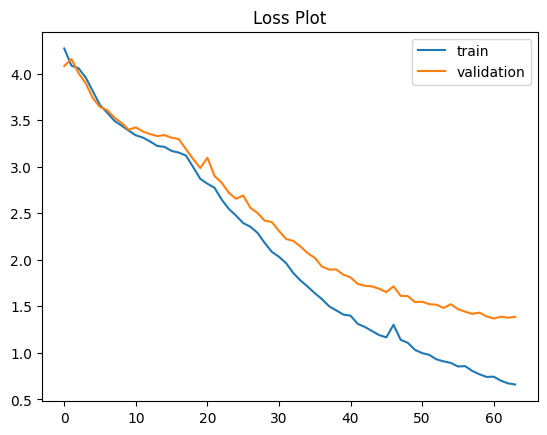

In [ ]:
# Plot the loss
plt.title('Loss Plot')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

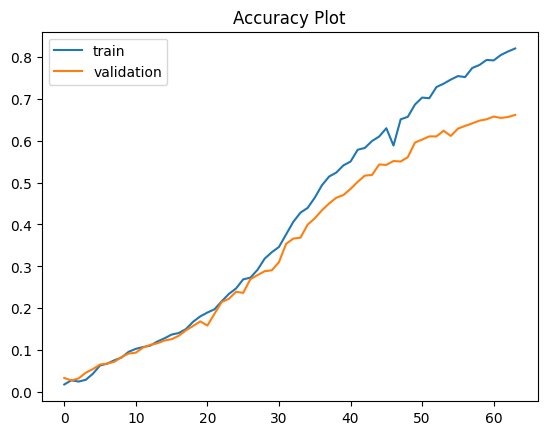

In [ ]:
# Plot the accuracy
plt.title('Accuracy Plot')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.show()

In [ ]:
# Load the saved model
saved_model = tf.keras.models.load_model(model_checkpoint_path)

# Evaluate the model with the test set
loss, accuracy = saved_model.evaluate(X_test_padded, y_test_array)

print("Test Loss:", loss)
print("Test Accuracy:", round((accuracy*100), 2))

97/97 [==============================] - 2s 8ms/step - loss: 1.3496 - accuracy: 0.6834
Test Loss: 1.349645972251892
Test Accuracy: 68.34


In [ ]:
# Check predictions with the test set
y_test_prob = saved_model.predict(X_test_padded)

# Convert probabilities to class labels
y_test_pred = np.argmax(y_test_prob, axis=1)

# Calculate precision, recall, and f1 score
precision = precision_score(y_test_array, y_test_pred, average='weighted')
recall = recall_score(y_test_array, y_test_pred, average='weighted')
f1 = f1_score(y_test_array, y_test_pred, average='weighted')

print("Precision:", round((precision*100), 2))
print("Recall:", round((recall*100), 2))
print("F1 Score:", round((f1*100), 2))

97/97 [==============================] - 2s 9ms/step
Precision: 68.85
Recall: 68.34
F1 Score: 67.45


In [ ]:
# Error analysis

# Print classification report
print(classification_report(y_test_array, y_test_pred))

# Check misclassified data
misclassified_data = np.where(y_test_pred != y_test_array)[0]
print(f"The number of misclassifications: {len(misclassified_data)}")

# Check the ratio of misclassifications
misclassification_ratio = (len(misclassified_data) / len(y_test_array)) * 100
# Round the number
rounded_ratio = round(misclassification_ratio, 2)
print(f"Proportion of misclassifications: {rounded_ratio}%")

# Iterate over misclassified data for error analysis
for idx in misclassified_data[:30]:
    input_text = X_test[idx]
    true_label = y_test[idx]
    predicted_label = y_test_pred[idx]

    # Print information about the misclassified data
    print("Input Text:", input_text)
    print("Actual Label:", true_label)
    print("Predicted Label:", predicted_label)
    print()

              precision    recall  f1-score   support

           0       0.77      0.90      0.83        40
           1       0.89      0.85      0.87        40
           2       0.83      0.97      0.90        40
           3       0.80      0.60      0.69        40
           4       0.79      0.82      0.80        40
           5       0.54      0.78      0.64        40
           6       0.66      0.72      0.69        40
           7       0.66      0.72      0.69        40
           8       0.75      0.82      0.79        40
           9       0.92      0.85      0.88        40
          10       0.55      0.15      0.24        40
          11       0.70      0.78      0.74        40
          12       0.71      0.60      0.65        40
          13       0.94      0.80      0.86        40
          14       0.38      0.60      0.46        40
          15       0.69      0.88      0.77        40
          16       0.58      0.70      0.64        40
          17       0.82    

### Hyperparameter tuning

In [ ]:
# The code for hyperparameter tuning is derived from the Tensorflow website.
# (https://www.tensorflow.org/tutorials/keras/keras_tuner)

# Import and install libraries for hyperparameter tuning
import IPython
!pip install -q -U keras-tuner
import kerastuner as kt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.4 MB/s eta 0:00:00


<ipython-input-81-8b29936803b5>:7: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


In [ ]:
# The code for hyperparameter tuning is derived from the Tensorflow website.
# (https://www.tensorflow.org/tutorials/keras/keras_tuner)

# Define the model for hyperparameter tuning
def model_builder(hp):
  model = keras.models.Sequential()
  model.add(layers.Embedding(voca_size, embedding_output_dim)) # Use the same dimension from the baseline model
  hp_units = hp.Int('units', min_value = 20, max_value = 50, step = 10) # Set up the hyperparameters
  model.add(layers.LSTM(units = hp_units)) # We will check the optimal hidden unit for the LSTM layer
  model.add(layers.Dense(nlabel, activation='softmax'))

  hp_learning_rate = hp.Choice('learning_rate', values = [0.01, 0.001, 0.0001]) # Set up the hyperparameters
  model.compile(optimizer = keras.optimizers.Adam(learning_rate = hp_learning_rate), # We will check the optimal learning rate
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  return model

In [ ]:
# The code for hyperparameter tuning is derived from the Tensorflow website.
# (https://www.tensorflow.org/tutorials/keras/keras_tuner)

# Specify the tuner
tuner = kt.Hyperband(model_builder,
                     objective = 'val_accuracy',
                     max_epochs = 100)

In [ ]:
# The code for hyperparameter tuning is derived from the Tensorflow website.
# (https://www.tensorflow.org/tutorials/keras/keras_tuner)

# Set up a callback for early stopping
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
# The code for hyperparameter tuning is derived from the Tensorflow website.
# (https://www.tensorflow.org/tutorials/keras/keras_tuner)

# Run the tuner
tuner.search(X_train_padded, y_train, epochs = 100, validation_data = (X_val_padded, y_val), callbacks = [stop_early])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"The optimal number of units: {best_hps.get('units')}. The optimal learning rate: {best_hps.get('learning_rate')}.")

The optimal number of units: 40. The optimal learning rate: 0.001.


### Tuned LSTM

In [ ]:
# Define the output dimension for the embedding layer and hidden units
embedding_output_dim = 100 # Random number
hidden_unit = 40 # Number from hyperparameter tuning
nlabel = 77 # number of classes

# Build the baseline model
tuned_model = keras.models.Sequential()
tuned_model.add(layers.Embedding(voca_size, embedding_output_dim))
tuned_model.add(layers.LSTM(hidden_unit))
tuned_model.add(layers.Dense(nlabel, activation='softmax'))

# Compile the model
tuned_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy']) # 0.001 is the default of Adam

# Summary the model
tuned_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 100)         208800    
                                                                 
 lstm_2 (LSTM)               (None, 40)                22560     
                                                                 
 dense_2 (Dense)             (None, 77)                3157      
                                                                 
Total params: 234517 (916.08 KB)
Trainable params: 234517 (916.08 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Define the folder path to save the model
folder_path = '/content/drive/MyDrive/Colab Notebooks/Classifying Bank Customer Service Questions/models/LSTM/'

# Define the file path for the model checkpoint
model_checkpoint_path = folder_path + 'tuned_LSTM_embedding_model.keras'

# Define the model checkpoint
mc = tf.keras.callbacks.ModelCheckpoint(
    filepath=model_checkpoint_path,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
# Import time to measure the elapsed time
import time

# Measure time before training
start_time = time.time()

# Fit the model
history = tuned_model.fit(
    X_train_padded, y_train,
    epochs = 100, # Random number
    validation_data = (X_val_padded, y_val),
    callbacks = [mc, es],
    batch_size = 32)

# End the training time
end_time = time.time()

# Measure the training time
training_time = end_time - start_time
print("Total training time:", training_time, "seconds")

Epoch 1/100
230/230 [==============================] - 9s 28ms/step - loss: 4.2946 - accuracy: 0.0165 - val_loss: 4.0789 - val_accuracy: 0.0272
Epoch 2/100
230/230 [==============================] - 8s 34ms/step - loss: 4.0052 - accuracy: 0.0297 - val_loss: 3.9721 - val_accuracy: 0.0321
Epoch 3/100
230/230 [==============================] - 5s 23ms/step - loss: 3.9831 - accuracy: 0.0282 - val_loss: 3.9574 - val_accuracy: 0.0299
Epoch 4/100
230/230 [==============================] - 6s 27ms/step - loss: 3.9313 - accuracy: 0.0282 - val_loss: 3.9680 - val_accuracy: 0.0338
Epoch 5/100
230/230 [==============================] - 8s 36ms/step - loss: 3.9267 - accuracy: 0.0274 - val_loss: 3.9583 - val_accuracy: 0.0310
Epoch 6/100
230/230 [==============================] - 6s 25ms/step - loss: 3.9227 - accuracy: 0.0320 - val_loss: 3.9566 - val_accuracy: 0.0359
Epoch 7/100
230/230 [==============================] - 7s 33ms/step - loss: 3.8577 - accuracy: 0.0359 - val_loss: 3.8474 - val_accuracy:

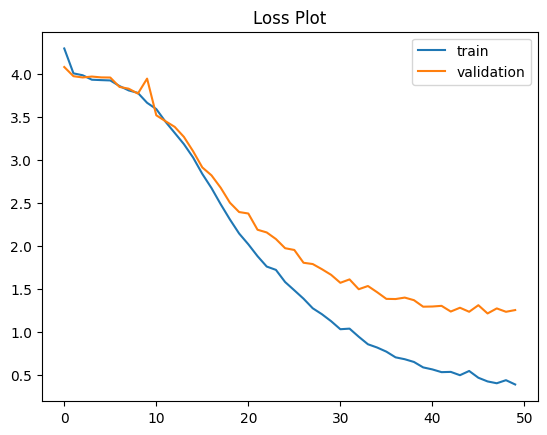

In [ ]:
# Plot the loss
plt.title('Loss Plot')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

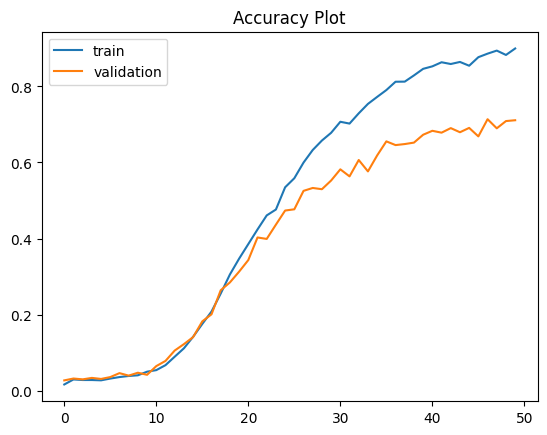

In [ ]:
# Plot the accuracy
plt.title('Accuracy Plot')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.show()

In [ ]:
# Load the saved model
saved_model = tf.keras.models.load_model(model_checkpoint_path)

# Evaluate the model with the test set
loss, accuracy = saved_model.evaluate(X_test_padded, y_test_array)

print("Test Loss:", loss)
print("Test Accuracy:", round((accuracy*100), 2))

97/97 [==============================] - 2s 7ms/step - loss: 1.1920 - accuracy: 0.7286
Test Loss: 1.1920427083969116
Test Accuracy: 72.86


In [ ]:
# Check predictions with the test set
y_test_prob = saved_model.predict(X_test_padded)

# Convert probabilities to class labels
y_test_pred = np.argmax(y_test_prob, axis=1)

# Calculate precision, recall, and f1 score
precision = precision_score(y_test_array, y_test_pred, average='weighted')
recall = recall_score(y_test_array, y_test_pred, average='weighted')
f1 = f1_score(y_test_array, y_test_pred, average='weighted')

print("Precision:", round((precision*100), 2))
print("Recall:", round((recall*100), 2))
print("F1 Score:", round((f1*100), 2))

97/97 [==============================] - 1s 6ms/step
Precision: 74.3
Recall: 72.86
F1 Score: 72.14


In [ ]:
# Error analysis

# Print classification report
print(classification_report(y_test_array, y_test_pred))

# Check misclassified data
misclassified_data = np.where(y_test_pred != y_test_array)[0]
print(f"The number of misclassifications: {len(misclassified_data)}")

# Check the ratio of misclassifications
misclassification_ratio = (len(misclassified_data) / len(y_test_array)) * 100
# Round the number
rounded_ratio = round(misclassification_ratio, 2)
print(f"Proportion of misclassifications: {rounded_ratio}%")

# Iterate over misclassified data for error analysis
for idx in misclassified_data[:30]:
    input_text = X_test[idx]
    true_label = y_test[idx]
    predicted_label = y_test_pred[idx]

    # Print information about the misclassified data
    print("Input Text:", input_text)
    print("Actual Label:", true_label)
    print("Predicted Label:", predicted_label)
    print()

              precision    recall  f1-score   support

           0       0.93      0.93      0.93        40
           1       0.68      0.75      0.71        40
           2       1.00      0.95      0.97        40
           3       0.80      0.80      0.80        40
           4       0.97      0.85      0.91        40
           5       0.58      0.78      0.67        40
           6       0.76      0.78      0.77        40
           7       0.89      0.78      0.83        40
           8       0.65      0.82      0.73        40
           9       0.90      0.90      0.90        40
          10       0.50      0.40      0.44        40
          11       0.65      0.65      0.65        40
          12       0.48      0.72      0.58        40
          13       0.71      0.85      0.77        40
          14       0.63      0.60      0.62        40
          15       0.68      0.80      0.74        40
          16       0.64      0.62      0.63        40
          17       0.74    

### Tuned LSTM (with dropout)

In [ ]:
# Define the output dimension for the embedding layer and hidden units
embedding_output_dim = 100 # Random number
hidden_unit = 40 # Number from hyperparameter tuning
nlabel = 77 # number of classes

# Build the baseline model
dropout_tuned_model = keras.models.Sequential()
dropout_tuned_model.add(layers.Embedding(voca_size, embedding_output_dim))
dropout_tuned_model.add(layers.LSTM(hidden_unit, dropout=0.2)) # Random number
dropout_tuned_model.add(layers.Dense(nlabel, activation='softmax'))

# Compile the model
dropout_tuned_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy']) # 0.001 is the default of Adam

# Summary the model
dropout_tuned_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, None, 100)         208800    
                                                                 
 lstm_5 (LSTM)               (None, 40)                22560     
                                                                 
 dense_5 (Dense)             (None, 77)                3157      
                                                                 
Total params: 234517 (916.08 KB)
Trainable params: 234517 (916.08 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Define the folder path to save the model
folder_path = '/content/drive/MyDrive/Colab Notebooks/Classifying Bank Customer Service Questions/models/LSTM/'

# Define the file path for the model checkpoint
model_checkpoint_path = folder_path + 'dropout_tuned_LSTM_embedding_model.keras'

# Define the model checkpoint
mc = tf.keras.callbacks.ModelCheckpoint(
    filepath=model_checkpoint_path,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
# Import time to measure the elapsed time
import time

# Measure time before training
start_time = time.time()

# Fit the model
history = dropout_tuned_model.fit(
    X_train_padded, y_train,
    epochs = 100, # Random number
    validation_data = (X_val_padded, y_val),
    callbacks = [mc, es],
    batch_size = 32)

# End the training time
end_time = time.time()

# Measure the training time
training_time = end_time - start_time
print("Total training time:", training_time, "seconds")

Epoch 1/100
230/230 [==============================] - 12s 39ms/step - loss: 4.2630 - accuracy: 0.0189 - val_loss: 4.1256 - val_accuracy: 0.0212
Epoch 2/100
230/230 [==============================] - 7s 31ms/step - loss: 3.9792 - accuracy: 0.0313 - val_loss: 3.9345 - val_accuracy: 0.0299
Epoch 3/100
230/230 [==============================] - 7s 32ms/step - loss: 3.9507 - accuracy: 0.0313 - val_loss: 3.9015 - val_accuracy: 0.0305
Epoch 4/100
230/230 [==============================] - 6s 26ms/step - loss: 3.9079 - accuracy: 0.0289 - val_loss: 3.9015 - val_accuracy: 0.0327
Epoch 5/100
230/230 [==============================] - 8s 34ms/step - loss: 3.8954 - accuracy: 0.0294 - val_loss: 3.8779 - val_accuracy: 0.0327
Epoch 6/100
230/230 [==============================] - 11s 46ms/step - loss: 4.0020 - accuracy: 0.0316 - val_loss: 3.9115 - val_accuracy: 0.0343
Epoch 7/100
230/230 [==============================] - 8s 34ms/step - loss: 3.9081 - accuracy: 0.0285 - val_loss: 3.8978 - val_accurac

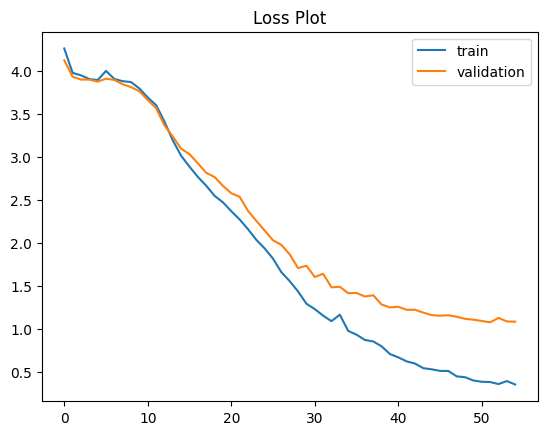

In [ ]:
# Plot the loss
plt.title('Loss Plot')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

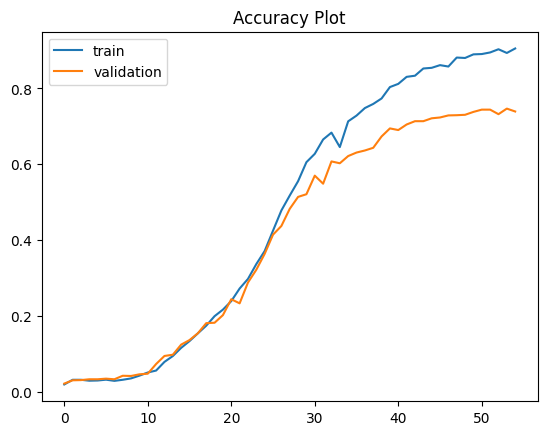

In [ ]:
# Plot the accuracy
plt.title('Accuracy Plot')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.show()

In [ ]:
# Load the saved model
saved_model = tf.keras.models.load_model(model_checkpoint_path)

# Evaluate the model with the test set
loss, accuracy = saved_model.evaluate(X_test_padded, y_test_array)

print("Test Loss:", loss)
print("Test Accuracy:", round((accuracy*100), 2))

97/97 [==============================] - 2s 7ms/step - loss: 1.0432 - accuracy: 0.7659
Test Loss: 1.0432207584381104
Test Accuracy: 76.59


In [ ]:
# Check predictions with the test set
y_test_prob = saved_model.predict(X_test_padded)

# Convert probabilities to class labels
y_test_pred = np.argmax(y_test_prob, axis=1)

# Calculate precision, recall, and f1 score
precision = precision_score(y_test_array, y_test_pred, average='weighted')
recall = recall_score(y_test_array, y_test_pred, average='weighted')
f1 = f1_score(y_test_array, y_test_pred, average='weighted')

print("Precision:", round((precision*100), 2))
print("Recall:", round((recall*100), 2))
print("F1 Score:", round((f1*100), 2))

97/97 [==============================] - 1s 7ms/step
Precision: 77.65
Recall: 76.59
F1 Score: 76.47


In [ ]:
# Error analysis

# Print classification report
print(classification_report(y_test_array, y_test_pred))

# Check misclassified data
misclassified_data = np.where(y_test_pred != y_test_array)[0]
print(f"The number of misclassifications: {len(misclassified_data)}")

# Check the ratio of misclassifications
misclassification_ratio = (len(misclassified_data) / len(y_test_array)) * 100
# Round the number
rounded_ratio = round(misclassification_ratio, 2)
print(f"Proportion of misclassifications: {rounded_ratio}%")

# Iterate over misclassified data for error analysis
for idx in misclassified_data[:30]:
    input_text = X_test[idx]
    true_label = y_test[idx]
    predicted_label = y_test_pred[idx]

    # Print information about the misclassified data
    print("Input Text:", input_text)
    print("Actual Label:", true_label)
    print("Predicted Label:", predicted_label)
    print()

              precision    recall  f1-score   support

           0       0.95      0.95      0.95        40
           1       1.00      0.95      0.97        40
           2       0.97      0.97      0.97        40
           3       0.92      0.60      0.73        40
           4       0.91      0.80      0.85        40
           5       0.55      0.78      0.65        40
           6       0.85      0.85      0.85        40
           7       0.82      0.78      0.79        40
           8       0.87      0.82      0.85        40
           9       0.97      0.88      0.92        40
          10       0.58      0.45      0.51        40
          11       0.85      0.82      0.84        40
          12       0.56      0.62      0.59        40
          13       0.90      0.93      0.91        40
          14       0.77      0.85      0.81        40
          15       0.72      0.78      0.75        40
          16       0.59      0.55      0.57        40
          17       0.85    

**The LSTM with baseline architecture and dropout has the best performance.**

## LSTM (with Word2Vec)

### Set up the Word2Vec model

In [ ]:
# Import and install the library and file for Word2Vec
import gensim

!pip install gdown # Install google download
!gdown https://drive.google.com/uc?id=1Av37IVBQAAntSe1X3MOAl5gvowQzd2_j # Download the Word2Vec (GoogleNews-vectors-negative300.bin.gz)

# Define the Word2Vec model
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

Downloading...
From (original): https://drive.google.com/uc?id=1Av37IVBQAAntSe1X3MOAl5gvowQzd2_j
From (redirected): https://drive.google.com/uc?id=1Av37IVBQAAntSe1X3MOAl5gvowQzd2_j&confirm=t&uuid=4335f280-bffc-48d7-a335-0876702f458b
To: /content/GoogleNews-vectors-negative300.bin.gz
100% 1.65G/1.65G [00:18<00:00, 87.9MB/s]


In [ ]:
# Check the model's dimension
print(f'Word2Vec: {word2vec_model.vectors.shape}')

Word2Vec: (3000000, 300)


In [ ]:
# Define the embedding matrix
embedding_matrix = np.zeros((voca_size+1, 300)) # For future dimension matching with the word_index, add 1 to the vocabulary size, and match 300 from Word2Vec
print(f'The shape of embedding matrix: {np.shape(embedding_matrix)}')

The shape of embedding matrix: (2089, 300)


In [ ]:
# Match words in the word_index to those in the word2vec_model for creating embedding matrix indices
def extract_vector(word):
    if word in word2vec_model:
        return word2vec_model[word]
    else:
        return None

In [ ]:
# Match the index and word to creat an embedding matrix
for word, index in word_index.items():
    vector_value = extract_vector(word)
    if vector_value is not None:
        embedding_matrix[index] = vector_value

In [ ]:
# Check the word 'card' vectors in the Word2Vec model
print(word2vec_model['card'])

[-1.63085938e-01  1.43554688e-01  1.97265625e-01  1.57226562e-01
  4.12597656e-02  2.43164062e-01 -2.21679688e-01 -5.02929688e-02
 -4.88281250e-02 -3.45703125e-01  4.18090820e-03 -8.10546875e-02
 -2.00195312e-01 -2.27539062e-01  4.41894531e-02 -1.96533203e-02
  2.83203125e-01  9.52148438e-02  8.74023438e-02 -2.69531250e-01
  2.27539062e-01  5.34667969e-02 -1.63574219e-02  3.97949219e-02
 -2.97851562e-02 -1.83105469e-02 -8.64257812e-02  9.96093750e-02
  3.33984375e-01  1.70898438e-02 -4.88281250e-02 -9.57031250e-02
  2.73437500e-01  1.33789062e-01 -5.90820312e-02  6.93359375e-02
  4.51660156e-02  1.31835938e-01 -1.74804688e-01 -2.12402344e-02
 -1.53198242e-02  8.78906250e-03  3.78906250e-01 -1.36718750e-01
  2.13867188e-01 -2.43164062e-01  2.70996094e-02  4.88281250e-02
 -3.56445312e-02 -3.19824219e-02 -3.90625000e-01  2.40234375e-01
  9.96093750e-02 -1.36718750e-01 -1.52343750e-01  3.14941406e-02
 -1.62109375e-01 -1.44531250e-01  2.33398438e-01 -1.55273438e-01
  1.92382812e-01  1.95312

In [ ]:
# Check the index of the word 'card' in word_index
print(f"The index of card in word_index: {word_index['card']}")

The index of card in word_index: 1


In [ ]:
# Check the word 'card' vectors in the embedding matrix
print(embedding_matrix[1])

[-1.63085938e-01  1.43554688e-01  1.97265625e-01  1.57226562e-01
  4.12597656e-02  2.43164062e-01 -2.21679688e-01 -5.02929688e-02
 -4.88281250e-02 -3.45703125e-01  4.18090820e-03 -8.10546875e-02
 -2.00195312e-01 -2.27539062e-01  4.41894531e-02 -1.96533203e-02
  2.83203125e-01  9.52148438e-02  8.74023438e-02 -2.69531250e-01
  2.27539062e-01  5.34667969e-02 -1.63574219e-02  3.97949219e-02
 -2.97851562e-02 -1.83105469e-02 -8.64257812e-02  9.96093750e-02
  3.33984375e-01  1.70898438e-02 -4.88281250e-02 -9.57031250e-02
  2.73437500e-01  1.33789062e-01 -5.90820312e-02  6.93359375e-02
  4.51660156e-02  1.31835938e-01 -1.74804688e-01 -2.12402344e-02
 -1.53198242e-02  8.78906250e-03  3.78906250e-01 -1.36718750e-01
  2.13867188e-01 -2.43164062e-01  2.70996094e-02  4.88281250e-02
 -3.56445312e-02 -3.19824219e-02 -3.90625000e-01  2.40234375e-01
  9.96093750e-02 -1.36718750e-01 -1.52343750e-01  3.14941406e-02
 -1.62109375e-01 -1.44531250e-01  2.33398438e-01 -1.55273438e-01
  1.92382812e-01  1.95312

In [ ]:
# Check the word 'topup' vectors in the Word2Vec model
print(word2vec_model['topup'])

[ 5.17578125e-02 -1.61132812e-01 -1.33789062e-01  1.93359375e-01
 -1.39770508e-02  1.69921875e-01  1.06933594e-01 -2.08007812e-01
  7.81250000e-02  1.11816406e-01  3.82995605e-03  2.55126953e-02
 -2.75390625e-01 -9.71679688e-02 -2.84423828e-02  1.31835938e-01
  2.27539062e-01  2.29492188e-02  1.18652344e-01  6.03027344e-02
 -1.92871094e-02 -6.15234375e-02  1.73828125e-01  1.72851562e-01
  2.50244141e-02 -1.54296875e-01 -1.62109375e-01  1.02539062e-01
  1.50146484e-02 -7.42187500e-02 -2.60009766e-02  4.98046875e-02
 -3.32031250e-02 -1.01074219e-01 -5.34667969e-02 -2.45117188e-01
 -1.04003906e-01 -1.25976562e-01 -7.86132812e-02  6.44531250e-02
 -2.86865234e-02 -3.44238281e-02  3.75976562e-02 -1.87500000e-01
 -4.78515625e-02 -3.53515625e-01 -1.01318359e-02  3.97949219e-02
 -1.40625000e-01 -1.69921875e-01  3.11279297e-02 -5.27343750e-02
  1.09863281e-01 -7.35473633e-03 -4.27246094e-02  3.00292969e-02
 -3.08593750e-01  1.87988281e-02  2.20947266e-02 -1.17675781e-01
 -1.70898438e-01 -2.04101

In [ ]:
# Check the index of the word 'topup' in word_index
print(f"The index of topup in word_index: {word_index['topup']}")

The index of topup in word_index: 19


In [ ]:
# Check the word 'topup' vectors in the embedding matrix
print(embedding_matrix[20])

[ 0.04980469  0.06640625  0.03833008  0.02355957 -0.02148438  0.20898438
  0.06396484 -0.02282715 -0.04101562 -0.26757812  0.1015625   0.10693359
 -0.06591797  0.16992188 -0.0078125  -0.07861328 -0.06591797  0.12060547
 -0.00390625 -0.02770996  0.19238281  0.13183594  0.16113281 -0.07324219
 -0.22167969 -0.05102539 -0.12255859  0.06298828  0.01080322 -0.12695312
  0.04614258 -0.01794434 -0.03222656 -0.21484375 -0.01696777  0.0098877
 -0.00976562 -0.05175781  0.12011719  0.04980469  0.01867676  0.05712891
 -0.04492188 -0.16113281 -0.08105469 -0.09960938 -0.19824219 -0.00109863
  0.01239014  0.23144531 -0.06738281  0.08105469 -0.0177002  -0.12402344
 -0.14746094 -0.10253906 -0.23046875 -0.03149414  0.03125    -0.09033203
  0.08251953 -0.09326172 -0.21679688  0.06103516  0.046875   -0.03466797
 -0.05908203  0.12695312 -0.0025177   0.08251953  0.0703125  -0.01037598
  0.08447266  0.006073   -0.12988281 -0.06689453  0.18359375  0.21191406
  0.01495361 -0.04907227 -0.01525879  0.07080078 -0.

### LSTM (baseline)

In [ ]:
# Define the output dimension for the embedding layer and hidden units
hidden_unit = 30
nlabel = 77

model = keras.models.Sequential()
e = layers.Embedding(voca_size+1, 300, weights=[embedding_matrix], input_length=max_length_train_text, trainable=False)
model.add(e)
model.add(layers.LSTM(hidden_unit))
model.add(layers.Dense(nlabel, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Summary the model
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 29, 300)           626700    
                                                                 
 lstm_6 (LSTM)               (None, 30)                39720     
                                                                 
 dense_6 (Dense)             (None, 77)                2387      
                                                                 
Total params: 668807 (2.55 MB)
Trainable params: 42107 (164.48 KB)
Non-trainable params: 626700 (2.39 MB)
_________________________________________________________________


In [ ]:
# Define the folder path to save the model
folder_path = '/content/drive/MyDrive/Colab Notebooks/Classifying Bank Customer Service Questions/models/LSTM/'

# Define the file path for the model checkpoint
model_checkpoint_path = folder_path + 'LSTM_word2vec_model.keras'

# Define the model checkpoint
mc = tf.keras.callbacks.ModelCheckpoint(
    filepath=model_checkpoint_path,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
# Define early stopping
es =  tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3) # Random number of patience

In [ ]:
# Import time to measure the elapsed time
import time

# Measure time before training
start_time = time.time()

# Fit the model
history = model.fit(
    X_train_padded, y_train,
    epochs = 100,
    validation_data = (X_val_padded, y_val),
    callbacks = [mc, es],
    batch_size = 32)

# End the training time
end_time = time.time()

# Measure the training time
training_time = end_time - start_time
print("Training time:", training_time, "seconds")

Epoch 1/100
230/230 [==============================] - 17s 60ms/step - loss: 4.1156 - accuracy: 0.0242 - val_loss: 3.8803 - val_accuracy: 0.0397
Epoch 2/100
230/230 [==============================] - 10s 43ms/step - loss: 3.8250 - accuracy: 0.0403 - val_loss: 3.7300 - val_accuracy: 0.0332
Epoch 3/100
230/230 [==============================] - 12s 54ms/step - loss: 3.6964 - accuracy: 0.0448 - val_loss: 3.6242 - val_accuracy: 0.0577
Epoch 4/100
230/230 [==============================] - 11s 47ms/step - loss: 3.6885 - accuracy: 0.0483 - val_loss: 3.7484 - val_accuracy: 0.0457
Epoch 5/100
230/230 [==============================] - 8s 36ms/step - loss: 3.5730 - accuracy: 0.0559 - val_loss: 3.4992 - val_accuracy: 0.0626
Epoch 6/100
230/230 [==============================] - 10s 43ms/step - loss: 3.4550 - accuracy: 0.0595 - val_loss: 3.4535 - val_accuracy: 0.0735
Epoch 7/100
230/230 [==============================] - 8s 37ms/step - loss: 3.3899 - accuracy: 0.0670 - val_loss: 3.3481 - val_accu

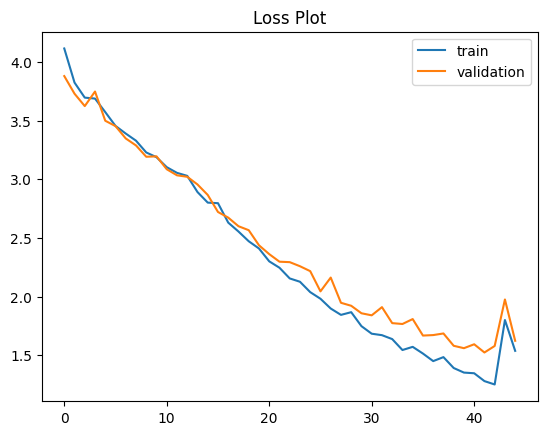

In [ ]:
# Plot the loss
plt.title('Loss Plot')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

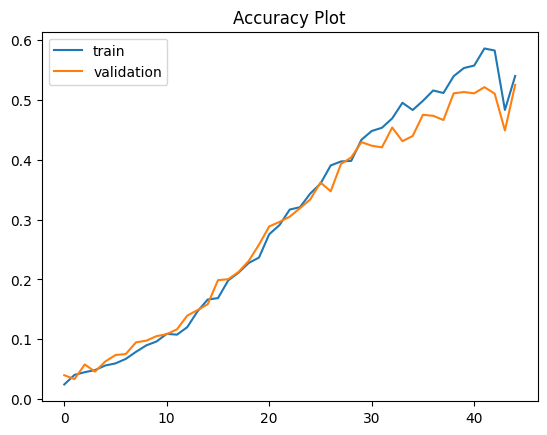

In [ ]:
# Plot the accuracy
plt.title('Accuracy Plot')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.show()

In [ ]:
# Load the saved model
saved_model = tf.keras.models.load_model(model_checkpoint_path)

# Evaluate the model with the test set
loss, accuracy = saved_model.evaluate(X_test_padded, y_test_array)

print("Test Loss:", loss)
print("Test Accuracy:", round((accuracy*100), 2))

97/97 [==============================] - 4s 16ms/step - loss: 1.6655 - accuracy: 0.5049
Test Loss: 1.6655056476593018
Test Accuracy: 50.49


In [ ]:
# Check predictions with the test set
y_test_prob = saved_model.predict(X_test_padded)

# Convert probabilities to class labels
y_test_pred = np.argmax(y_test_prob, axis=1)

# Calculate precision, recall, and f1 score
precision = precision_score(y_test_array, y_test_pred, average='weighted')
recall = recall_score(y_test_array, y_test_pred, average='weighted')
f1 = f1_score(y_test_array, y_test_pred, average='weighted')

print("Precision:", round((precision*100), 2))
print("Recall:", round((recall*100), 2))
print("F1 Score:", round((f1*100), 2))

97/97 [==============================] - 3s 16ms/step
Precision: 49.75
Recall: 50.49
F1 Score: 46.57


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Error analysis

# Print classification report
print(classification_report(y_test_array, y_test_pred))

# Check misclassified data
misclassified_data = np.where(y_test_pred != y_test_array)[0]
print(f"The number of misclassifications: {len(misclassified_data)}")

# Check the ratio of misclassifications
misclassification_ratio = (len(misclassified_data) / len(y_test_array)) * 100
# Round the number
rounded_ratio = round(misclassification_ratio, 2)
print(f"Proportion of misclassifications: {rounded_ratio}%")

# Iterate over misclassified data for error analysis
for idx in misclassified_data[:30]:
    input_text = X_test[idx]
    true_label = y_test[idx]
    predicted_label = y_test_pred[idx]

    # Print information about the misclassified data
    print("Input Text:", input_text)
    print("Actual Label:", true_label)
    print("Predicted Label:", predicted_label)
    print()

              precision    recall  f1-score   support

           0       0.60      0.15      0.24        40
           1       0.29      0.57      0.39        40
           2       0.97      0.95      0.96        40
           3       0.00      0.00      0.00        40
           4       0.83      0.85      0.84        40
           5       0.37      0.62      0.46        40
           6       0.65      0.78      0.70        40
           7       0.50      0.72      0.59        40
           8       0.55      0.82      0.66        40
           9       0.86      0.62      0.72        40
          10       0.44      0.30      0.36        40
          11       0.43      0.82      0.56        40
          12       0.65      0.28      0.39        40
          13       0.36      0.70      0.47        40
          14       0.46      0.78      0.57        40
          15       0.58      0.85      0.69        40
          16       0.49      0.50      0.49        40
          17       0.88    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### LSTM (with dropout)

In [ ]:
# Define the output dimension for the embedding layer and hidden units
hidden_unit = 30
nlabel = 77

dropout_model = keras.models.Sequential()
e = layers.Embedding(voca_size+1, 300, weights=[embedding_matrix], input_length=max_length_train_text, trainable=False)
dropout_model.add(e)
dropout_model.add(layers.LSTM(hidden_unit, dropout=0.2))
dropout_model.add(layers.Dense(nlabel, activation='softmax'))

# Compile the model
dropout_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Summary the model
dropout_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 29, 300)           626700    
                                                                 
 lstm_7 (LSTM)               (None, 30)                39720     
                                                                 
 dense_7 (Dense)             (None, 77)                2387      
                                                                 
Total params: 668807 (2.55 MB)
Trainable params: 42107 (164.48 KB)
Non-trainable params: 626700 (2.39 MB)
_________________________________________________________________


In [ ]:
# Define the folder path to save the model
folder_path = '/content/drive/MyDrive/Colab Notebooks/Classifying Bank Customer Service Questions/models/LSTM/'

# Define the file path for the model checkpoint
model_checkpoint_path = folder_path + 'dropout_LSTM_word2vec_model.keras'

# Define the model checkpoint
mc = tf.keras.callbacks.ModelCheckpoint(
    filepath=model_checkpoint_path,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
# Import time to measure the elapsed time
import time

# Measure time before training
start_time = time.time()

# Fit the model
history = dropout_model.fit(
    X_train_padded, y_train,
    epochs = 100,
    validation_data = (X_val_padded, y_val),
    callbacks = [mc, es],
    batch_size = 32)

# End the training time
end_time = time.time()

# Measure the training time
training_time = end_time - start_time
print("Training time:", training_time, "seconds")

Epoch 1/100
230/230 [==============================] - 10s 32ms/step - loss: 4.1376 - accuracy: 0.0193 - val_loss: 3.9000 - val_accuracy: 0.0321
Epoch 2/100
230/230 [==============================] - 6s 25ms/step - loss: 3.8377 - accuracy: 0.0366 - val_loss: 3.7534 - val_accuracy: 0.0359
Epoch 3/100
230/230 [==============================] - 10s 45ms/step - loss: 3.7450 - accuracy: 0.0395 - val_loss: 3.6682 - val_accuracy: 0.0555
Epoch 4/100
230/230 [==============================] - 12s 50ms/step - loss: 3.6308 - accuracy: 0.0502 - val_loss: 3.5310 - val_accuracy: 0.0670
Epoch 5/100
230/230 [==============================] - 13s 55ms/step - loss: 3.4824 - accuracy: 0.0682 - val_loss: 3.3377 - val_accuracy: 0.0773
Epoch 6/100
230/230 [==============================] - 20s 87ms/step - loss: 3.3260 - accuracy: 0.0791 - val_loss: 3.2037 - val_accuracy: 0.0936
Epoch 7/100
230/230 [==============================] - 14s 63ms/step - loss: 3.2143 - accuracy: 0.0913 - val_loss: 3.1157 - val_acc

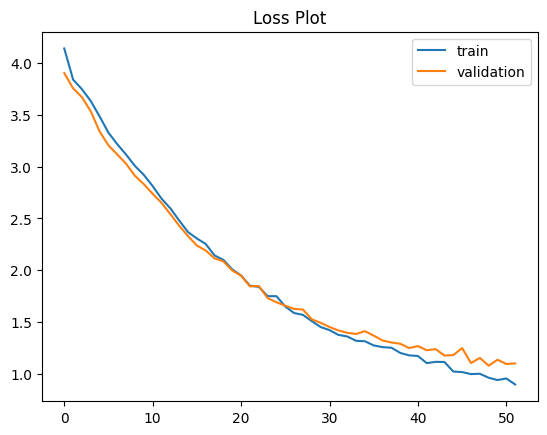

In [ ]:
# Plot the loss
plt.title('Loss Plot')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

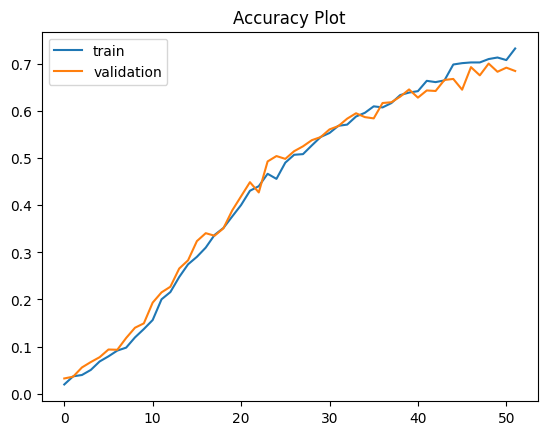

In [ ]:
# Plot the accuracy
plt.title('Accuracy Plot')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.show()

In [ ]:
# Load the saved model
saved_model = tf.keras.models.load_model(model_checkpoint_path)

# Evaluate the model with the test set
loss, accuracy = saved_model.evaluate(X_test_padded, y_test_array)

print("Test Loss:", loss)
print("Test Accuracy:", round((accuracy*100), 2))

97/97 [==============================] - 2s 9ms/step - loss: 1.1089 - accuracy: 0.7000
Test Loss: 1.108872652053833
Test Accuracy: 70.0


In [ ]:
# Check predictions with the test set
y_test_prob = saved_model.predict(X_test_padded)

# Convert probabilities to class labels
y_test_pred = np.argmax(y_test_prob, axis=1)

# Calculate precision, recall, and f1 score
precision = precision_score(y_test_array, y_test_pred, average='weighted')
recall = recall_score(y_test_array, y_test_pred, average='weighted')
f1 = f1_score(y_test_array, y_test_pred, average='weighted')

print("Precision:", round((precision*100), 2))
print("Recall:", round((recall*100), 2))
print("F1 Score:", round((f1*100), 2))

97/97 [==============================] - 1s 9ms/step
Precision: 70.48
Recall: 70.0
F1 Score: 68.02


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Error analysis

# Print classification report
print(classification_report(y_test_array, y_test_pred))

# Check misclassified data
misclassified_data = np.where(y_test_pred != y_test_array)[0]
print(f"The number of misclassifications: {len(misclassified_data)}")

# Check the ratio of misclassifications
misclassification_ratio = (len(misclassified_data) / len(y_test_array)) * 100
# Round the number
rounded_ratio = round(misclassification_ratio, 2)
print(f"Proportion of misclassifications: {rounded_ratio}%")

# Iterate over misclassified data for error analysis
for idx in misclassified_data[:30]:
    input_text = X_test[idx]
    true_label = y_test[idx]
    predicted_label = y_test_pred[idx]

    # Print information about the misclassified data
    print("Input Text:", input_text)
    print("Actual Label:", true_label)
    print("Predicted Label:", predicted_label)
    print()

              precision    recall  f1-score   support

           0       0.92      0.90      0.91        40
           1       0.90      0.95      0.93        40
           2       1.00      0.97      0.99        40
           3       0.72      0.33      0.45        40
           4       0.96      0.68      0.79        40
           5       0.47      0.68      0.55        40
           6       0.81      0.85      0.83        40
           7       0.50      0.35      0.41        40
           8       0.80      0.80      0.80        40
           9       0.95      0.93      0.94        40
          10       0.78      0.53      0.63        40
          11       0.52      0.65      0.58        40
          12       0.90      0.47      0.62        40
          13       0.62      0.88      0.73        40
          14       0.43      0.70      0.53        40
          15       0.71      0.88      0.79        40
          16       0.56      0.70      0.62        40
          17       0.84    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Hyperparameter tuning

In [ ]:
# The code for hyperparameter tuning is derived from the Tensorflow website.
# (https://www.tensorflow.org/tutorials/keras/keras_tuner)

# Define the model for hyperparameter tuning
def model_builder(hp):
  model = keras.models.Sequential()
  e = layers.Embedding(voca_size+1, 300, weights=[embedding_matrix], input_length=max_length_train_text, trainable=False)
  model.add(e)
  hp_units = hp.Int('units', min_value = 20, max_value = 50, step = 10) # Set up the hyperparameters
  model.add(layers.LSTM(units = hp_units)) # We will check the optimal hidden unit for the LSTM layer
  model.add(layers.Dense(nlabel, activation='softmax'))

  hp_learning_rate = hp.Choice('learning_rate', values = [0.01, 0.001, 0.0001]) # Set up the hyperparameters
  model.compile(optimizer = keras.optimizers.Adam(learning_rate = hp_learning_rate), # We will check the optimal learning rate
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  return model

In [ ]:
# The code for hyperparameter tuning is derived from the Tensorflow website.
# (https://www.tensorflow.org/tutorials/keras/keras_tuner)

# Specify the tuner
tuner = kt.Hyperband(model_builder,
                     objective = 'val_accuracy',
                     max_epochs = 100)

In [ ]:
# The code for hyperparameter tuning is derived from the Tensorflow website.
# (https://www.tensorflow.org/tutorials/keras/keras_tuner)

# Set up a callback for early stopping
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
# The code for hyperparameter tuning is derived from the Tensorflow website.
# (https://www.tensorflow.org/tutorials/keras/keras_tuner)

# Run the tuner
tuner.search(X_train_padded, y_train, epochs = 100, validation_data = (X_val_padded, y_val), callbacks = [stop_early])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"The optimal number of units: {best_hps.get('units')}. The optimal learning rate: {best_hps.get('learning_rate')}.")

Trial 12 Complete [00h 00m 13s]
val_accuracy: 0.03647251054644585

Best val_accuracy So Far: 0.17038649320602417
Total elapsed time: 00h 24m 36s
The optimal number of units: 50. The optimal learning rate: 0.01.


### Tuned LSTM

In [ ]:
# Define the output dimension for the embedding layer and hidden units
nlabel = 77

tuned_model = keras.models.Sequential()
e = layers.Embedding(voca_size+1, 300, weights=[embedding_matrix], input_length=max_length_train_text, trainable=False)
tuned_model.add(e)
tuned_model.add(layers.LSTM(50))
tuned_model.add(layers.Dense(nlabel, activation='softmax'))

# Compile the model
tuned_model.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Summary the model
tuned_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 29, 300)           626700    
                                                                 
 lstm_8 (LSTM)               (None, 50)                70200     
                                                                 
 dense_8 (Dense)             (None, 77)                3927      
                                                                 
Total params: 700827 (2.67 MB)
Trainable params: 74127 (289.56 KB)
Non-trainable params: 626700 (2.39 MB)
_________________________________________________________________


In [ ]:
# Define the folder path to save the model
folder_path = '/content/drive/MyDrive/Colab Notebooks/Classifying Bank Customer Service Questions/models/LSTM/'

# Define the file path for the model checkpoint
model_checkpoint_path = folder_path + 'tuned_LSTM_word2vec_model.keras'

# Define the model checkpoint
mc = tf.keras.callbacks.ModelCheckpoint(
    filepath=model_checkpoint_path,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
# Import time to measure the elapsed time
import time

# Measure time before training
start_time = time.time()

# Fit the model
history = tuned_model.fit(
    X_train_padded, y_train,
    epochs = 100,
    validation_data = (X_val_padded, y_val),
    callbacks = [mc, es],
    batch_size = 32)

# End the training time
end_time = time.time()

# Measure the training time
training_time = end_time - start_time
print("Training time:", training_time, "seconds")

Epoch 1/100
230/230 [==============================] - 14s 49ms/step - loss: 4.1499 - accuracy: 0.0271 - val_loss: 4.1483 - val_accuracy: 0.0299
Epoch 2/100
230/230 [==============================] - 11s 48ms/step - loss: 4.2695 - accuracy: 0.0267 - val_loss: 4.2910 - val_accuracy: 0.0240
Epoch 3/100
230/230 [==============================] - 7s 29ms/step - loss: 4.1253 - accuracy: 0.0253 - val_loss: 4.0790 - val_accuracy: 0.0289
Epoch 4/100
230/230 [==============================] - 10s 45ms/step - loss: 3.7872 - accuracy: 0.0501 - val_loss: 3.4356 - val_accuracy: 0.0806
Epoch 5/100
230/230 [==============================] - 8s 33ms/step - loss: 3.2299 - accuracy: 0.1010 - val_loss: 2.9360 - val_accuracy: 0.1595
Epoch 6/100
230/230 [==============================] - 10s 44ms/step - loss: 2.6225 - accuracy: 0.2332 - val_loss: 2.2807 - val_accuracy: 0.3005
Epoch 7/100
230/230 [==============================] - 9s 38ms/step - loss: 1.9497 - accuracy: 0.3935 - val_loss: 1.7657 - val_accur

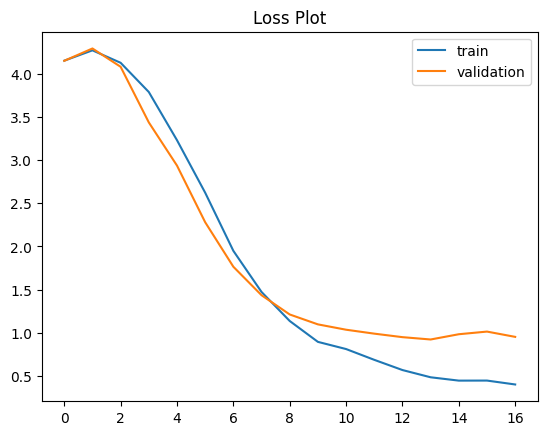

In [ ]:
# Plot the loss
plt.title('Loss Plot')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

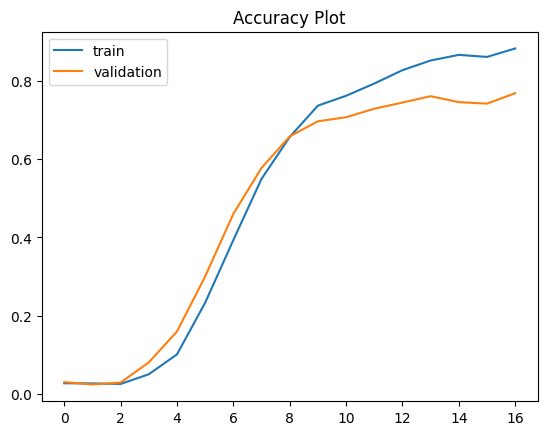

In [ ]:
# Plot the accuracy
plt.title('Accuracy Plot')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.show()

In [ ]:
# Load the saved model
saved_model = tf.keras.models.load_model(model_checkpoint_path)

# Evaluate the model with the test set
loss, accuracy = saved_model.evaluate(X_test_padded, y_test_array)

print("Test Loss:", loss)
print("Test Accuracy:", round((accuracy*100), 2))

97/97 [==============================] - 3s 22ms/step - loss: 0.8925 - accuracy: 0.7731
Test Loss: 0.892530083656311
Test Accuracy: 77.31


In [ ]:
# Check predictions with the test set
y_test_prob = saved_model.predict(X_test_padded)

# Convert probabilities to class labels
y_test_pred = np.argmax(y_test_prob, axis=1)

# Calculate precision, recall, and f1 score
precision = precision_score(y_test_array, y_test_pred, average='weighted')
recall = recall_score(y_test_array, y_test_pred, average='weighted')
f1 = f1_score(y_test_array, y_test_pred, average='weighted')

print("Precision:", round((precision*100), 2))
print("Recall:", round((recall*100), 2))
print("F1 Score:", round((f1*100), 2))

97/97 [==============================] - 2s 12ms/step
Precision: 78.87
Recall: 77.31
F1 Score: 77.25


In [ ]:
# Error analysis

# Print classification report
print(classification_report(y_test_array, y_test_pred))

# Check misclassified data
misclassified_data = np.where(y_test_pred != y_test_array)[0]
print(f"The number of misclassifications: {len(misclassified_data)}")

# Check the ratio of misclassifications
misclassification_ratio = (len(misclassified_data) / len(y_test_array)) * 100
# Round the number
rounded_ratio = round(misclassification_ratio, 2)
print(f"Proportion of misclassifications: {rounded_ratio}%")

# Iterate over misclassified data for error analysis
for idx in misclassified_data[:30]:
    input_text = X_test[idx]
    true_label = y_test[idx]
    predicted_label = y_test_pred[idx]

    # Print information about the misclassified data
    print("Input Text:", input_text)
    print("Actual Label:", true_label)
    print("Predicted Label:", predicted_label)
    print()

              precision    recall  f1-score   support

           0       0.93      0.95      0.94        40
           1       0.85      0.97      0.91        40
           2       0.97      0.97      0.97        40
           3       0.59      0.68      0.63        40
           4       0.85      0.70      0.77        40
           5       0.66      0.68      0.67        40
           6       0.74      0.78      0.76        40
           7       0.71      0.72      0.72        40
           8       0.86      0.80      0.83        40
           9       0.87      1.00      0.93        40
          10       0.69      0.50      0.58        40
          11       0.67      0.78      0.72        40
          12       0.68      0.75      0.71        40
          13       0.92      0.90      0.91        40
          14       0.55      0.82      0.66        40
          15       0.74      0.85      0.79        40
          16       0.56      0.55      0.56        40
          17       0.78    

### Tuned LSTM (with dropout)

In [ ]:
# Define the output dimension for the embedding layer and hidden units
nlabel = 77

dropout_tuned_model = keras.models.Sequential()
e = layers.Embedding(voca_size+1, 300, weights=[embedding_matrix], input_length=max_length_train_text, trainable=False)
dropout_tuned_model.add(e)
dropout_tuned_model.add(layers.LSTM(50, dropout=0.2))
dropout_tuned_model.add(layers.Dense(nlabel, activation='softmax'))

# Compile the model
dropout_tuned_model.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Summary the model
dropout_tuned_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 29, 300)           626700    
                                                                 
 lstm_9 (LSTM)               (None, 50)                70200     
                                                                 
 dense_9 (Dense)             (None, 77)                3927      
                                                                 
Total params: 700827 (2.67 MB)
Trainable params: 74127 (289.56 KB)
Non-trainable params: 626700 (2.39 MB)
_________________________________________________________________


In [ ]:
# Define the folder path to save the model
folder_path = '/content/drive/MyDrive/Colab Notebooks/Classifying Bank Customer Service Questions/models/LSTM/'

# Define the file path for the model checkpoint
model_checkpoint_path = folder_path + 'dropout_tuned_LSTM_word2vec_model.keras'

# Define the model checkpoint
mc = tf.keras.callbacks.ModelCheckpoint(
    filepath=model_checkpoint_path,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
# Get the weights of the embedding layer
embedding_weights = dropout_tuned_model.layers[0].get_weights()[0]

# Define the file path to save the weights
embedding_weights_file = '/content/drive/MyDrive/Colab Notebooks/Classifying Bank Customer Service Questions/embedding_weights.npy'

# Save the weights as a file
np.save(embedding_weights_file, embedding_weights)

In [ ]:
# Import time to measure the elapsed time
import time

# Measure time before training
start_time = time.time()

# Fit the model
history = dropout_tuned_model.fit(
    X_train_padded, y_train,
    epochs = 100,
    validation_data = (X_val_padded, y_val),
    callbacks = [mc, es],
    batch_size = 32)

# End the training time
end_time = time.time()

# Measure the training time
training_time = end_time - start_time
print("Training time:", training_time, "seconds")

Epoch 1/100
230/230 [==============================] - 16s 53ms/step - loss: 3.9733 - accuracy: 0.0348 - val_loss: 3.7733 - val_accuracy: 0.0474
Epoch 2/100
230/230 [==============================] - 10s 43ms/step - loss: 3.8154 - accuracy: 0.0566 - val_loss: 3.8087 - val_accuracy: 0.0637
Epoch 3/100
230/230 [==============================] - 10s 41ms/step - loss: 3.7495 - accuracy: 0.0709 - val_loss: 3.7288 - val_accuracy: 0.0680
Epoch 4/100
230/230 [==============================] - 11s 48ms/step - loss: 3.5694 - accuracy: 0.0957 - val_loss: 3.2373 - val_accuracy: 0.1214
Epoch 5/100
230/230 [==============================] - 8s 37ms/step - loss: 2.9182 - accuracy: 0.1797 - val_loss: 2.5324 - val_accuracy: 0.2548
Epoch 6/100
230/230 [==============================] - 11s 48ms/step - loss: 2.1847 - accuracy: 0.3357 - val_loss: 1.8590 - val_accuracy: 0.4192
Epoch 7/100
230/230 [==============================] - 12s 54ms/step - loss: 1.7277 - accuracy: 0.4684 - val_loss: 1.4882 - val_acc

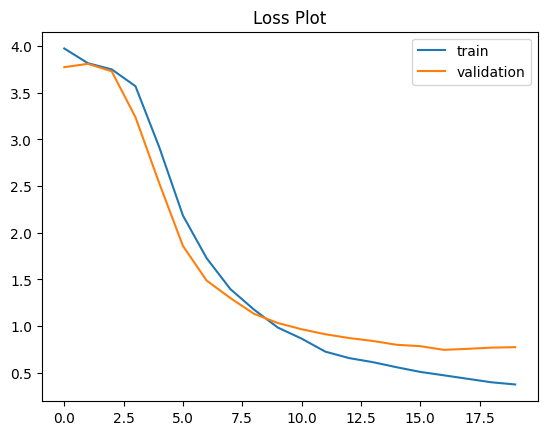

In [ ]:
# Plot the loss
plt.title('Loss Plot')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

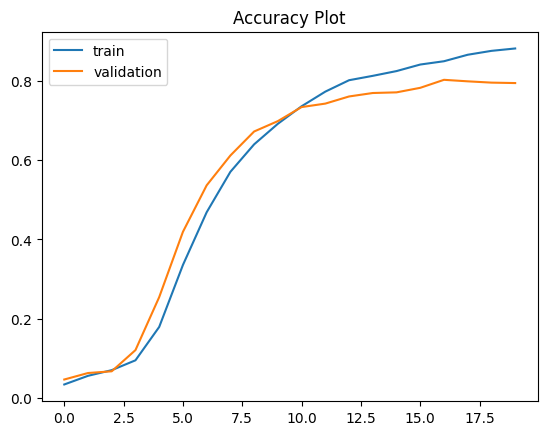

In [ ]:
# Plot the accuracy
plt.title('Accuracy Plot')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.show()

In [ ]:
# Load the saved model
saved_model = tf.keras.models.load_model(model_checkpoint_path)

# Evaluate the model with the test set
loss, accuracy = saved_model.evaluate(X_test_padded, y_test_array)

print("Test Loss:", loss)
print("Test Accuracy:", round((accuracy*100), 2))

97/97 [==============================] - 4s 25ms/step - loss: 0.7372 - accuracy: 0.7984
Test Loss: 0.7371559143066406
Test Accuracy: 79.84


In [ ]:
# Check predictions with the test set
y_test_prob = saved_model.predict(X_test_padded)

# Convert probabilities to class labels
y_test_pred = np.argmax(y_test_prob, axis=1)

# Calculate precision, recall, and f1 score
precision = precision_score(y_test_array, y_test_pred, average='weighted')
recall = recall_score(y_test_array, y_test_pred, average='weighted')
f1 = f1_score(y_test_array, y_test_pred, average='weighted')

print("Precision:", round((precision*100), 2))
print("Recall:", round((recall*100), 2))
print("F1 Score:", round((f1*100), 2))

97/97 [==============================] - 2s 13ms/step
Precision: 81.46
Recall: 79.84
F1 Score: 79.54


In [ ]:
# Error analysis

# Print classification report
print(classification_report(y_test_array, y_test_pred))

# Check misclassified data
misclassified_data = np.where(y_test_pred != y_test_array)[0]
print(f"The number of misclassifications: {len(misclassified_data)}")

# Check the ratio of misclassifications
misclassification_ratio = (len(misclassified_data) / len(y_test_array)) * 100
# Round the number
rounded_ratio = round(misclassification_ratio, 2)
print(f"Proportion of misclassifications: {rounded_ratio}%")

# Iterate over misclassified data for error analysis
for idx in misclassified_data[:30]:
    input_text = X_test[idx]
    true_label = y_test[idx]
    predicted_label = y_test_pred[idx]

    # Print information about the misclassified data
    print("Input Text:", input_text)
    print("Actual Label:", true_label)
    print("Predicted Label:", predicted_label)
    print()

              precision    recall  f1-score   support

           0       0.90      0.95      0.93        40
           1       0.90      0.95      0.93        40
           2       0.95      1.00      0.98        40
           3       0.58      0.70      0.64        40
           4       1.00      0.85      0.92        40
           5       0.70      0.65      0.68        40
           6       1.00      0.75      0.86        40
           7       0.79      0.68      0.73        40
           8       0.73      0.90      0.81        40
           9       0.85      0.97      0.91        40
          10       0.79      0.57      0.67        40
          11       0.87      0.68      0.76        40
          12       0.65      0.90      0.76        40
          13       0.93      0.95      0.94        40
          14       0.81      0.85      0.83        40
          15       0.80      0.80      0.80        40
          16       0.50      0.57      0.53        40
          17       0.79    

## LSTM (with GloVe)

### Set up the GloVe model

In [ ]:
# Define the embedding indez as a dictionary
embeddings_index = dict()

# Load the GLoVe file to the colab notebook
f = open('/content/drive/MyDrive/Colab Notebooks/Classifying Bank Customer Service Questions/glove.6B.100d.txt', encoding="utf8")
for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print(f'Total vectors in the GloVe file: {len(embeddings_index)}')

Total vectors in the GloVe file: 400001


In [ ]:
# Check the dimension of a word
print(f"The dimension of a word in embedding_index: {len(embeddings_index['card'])}")

The dimension of a word in embedding_index: 100


In [ ]:
# Define the embedding matrix
embedding_matrix = np.zeros((voca_size+1, 100)) # For future dimension matching with the word_index, add 1 to the vocabulary size, and match 100 from GloVe
print(f'The shape of embedding matrix: {np.shape(embedding_matrix)}')

The shape of embedding matrix: (2089, 100)


In [ ]:
# Check the index of the word 'card' in word_index
print(f"The index of card in word_index: {word_index['card']}")

The index of card in word_index: 1


In [ ]:
# Check the word 'card' vectors in the embedding index
print(embeddings_index['card'])

[ 1.6292e-01 -3.1798e-01  4.2328e-01 -8.6767e-01  4.5101e-01  5.7857e-01
  2.6645e-02 -1.2648e-01  3.3465e-01 -4.2047e-02 -4.0596e-02  1.6478e-01
 -6.7344e-01 -3.3751e-01  3.5913e-01  5.7383e-01  8.4620e-01  3.6374e-01
  3.0630e-01 -6.8050e-02 -6.7610e-01 -1.9147e-01 -1.4594e-01  3.2621e-03
  6.6949e-01 -3.3588e-01  1.7868e-01 -3.9360e-01  1.7700e-01 -3.3642e-01
  1.9288e-01  1.0030e+00 -2.1794e-01  2.4271e-01  1.0935e+00 -1.0303e-01
 -7.9197e-01 -1.3506e-01  1.2156e-01 -9.8377e-01  1.0300e+00 -1.0242e+00
  6.0269e-01 -1.5986e-01 -2.6773e-01 -5.5630e-01  2.5834e-01 -8.5021e-02
 -1.5221e-01 -3.3717e-01  2.6358e-02  2.3171e-01 -1.8056e-01  5.7107e-01
  3.8556e-01 -1.5732e+00 -1.4902e-01  3.7826e-02  1.8485e+00  7.0210e-01
 -1.1697e-01  7.7822e-02  7.4620e-02  9.9570e-02 -2.1427e-01 -6.0061e-01
  9.4903e-02  8.0589e-01  5.5333e-01 -3.1359e-01 -9.0991e-01  5.3645e-02
 -1.4494e-01 -4.8532e-01  1.0335e-01  1.2182e+00 -2.2199e-01 -1.4934e-02
 -1.1355e+00  3.2790e-01  1.1733e+00 -5.2838e-01 -6

In [ ]:
# Check the word 'topup' vectors in the embedding index
print(embeddings_index['topup'])

KeyError: 'topup'

There is no word 'topup'.

In [ ]:
# Match the index and word to creat an embedding matrix
for word, index in word_index.items():
    vector_value = embeddings_index.get(word)
    if vector_value is not None:
        embedding_matrix[index] = vector_value

In [ ]:
# Check the word 'card' vectors in the embedding matrix
print(embedding_matrix[1])

[ 1.62919998e-01 -3.17979991e-01  4.23280001e-01 -8.67670000e-01
  4.51009989e-01  5.78570008e-01  2.66449992e-02 -1.26479998e-01
  3.34650010e-01 -4.20470014e-02 -4.05960009e-02  1.64780006e-01
 -6.73439980e-01 -3.37509990e-01  3.59129995e-01  5.73830009e-01
  8.46199989e-01  3.63739997e-01  3.06300014e-01 -6.80499971e-02
 -6.76100016e-01 -1.91469997e-01 -1.45940006e-01  3.26210004e-03
  6.69489980e-01 -3.35880011e-01  1.78680003e-01 -3.93599987e-01
  1.77000001e-01 -3.36420000e-01  1.92880005e-01  1.00300002e+00
 -2.17940003e-01  2.42709994e-01  1.09350002e+00 -1.03030004e-01
 -7.91970015e-01 -1.35059997e-01  1.21560000e-01 -9.83770013e-01
  1.02999997e+00 -1.02419996e+00  6.02689981e-01 -1.59860000e-01
 -2.67729998e-01 -5.56299984e-01  2.58340001e-01 -8.50209966e-02
 -1.52209997e-01 -3.37170005e-01  2.63579991e-02  2.31710002e-01
 -1.80559993e-01  5.71070015e-01  3.85560006e-01 -1.57319999e+00
 -1.49020001e-01  3.78260016e-02  1.84850001e+00  7.02099979e-01
 -1.16970003e-01  7.78219

### LSTM (baseline)

In [ ]:
# Define the output dimension for the embedding layer and hidden units
hidden_unit = 30
nlabel = 77

model = keras.models.Sequential()
e = layers.Embedding(voca_size+1, 100, weights=[embedding_matrix], input_length=max_length_train_text, trainable=False) # Using 100 dimension for GloVe
model.add(e)
model.add(layers.LSTM(hidden_unit))
model.add(layers.Dense(nlabel, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy']) #, run_eagerly=True

# Summary the model
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 29, 100)           208900    
                                                                 
 lstm_10 (LSTM)              (None, 30)                15720     
                                                                 
 dense_10 (Dense)            (None, 77)                2387      
                                                                 
Total params: 227007 (886.75 KB)
Trainable params: 18107 (70.73 KB)
Non-trainable params: 208900 (816.02 KB)
_________________________________________________________________


In [ ]:
# Define the folder path to save the model
folder_path = '/content/drive/MyDrive/Colab Notebooks/Classifying Bank Customer Service Questions/models/LSTM/'

# Define the file path for the model checkpoint
model_checkpoint_path = folder_path + 'LSTM_glove_model.keras'

# Define the model checkpoint
mc = tf.keras.callbacks.ModelCheckpoint(
    filepath=model_checkpoint_path,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
# Define early stopping
es =  tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3) # Random number of patience

In [ ]:
# Import time to measure the elapsed time
import time

# Measure time before training
start_time = time.time()

# Fit the model
history = model.fit(
    X_train_padded, y_train,
    epochs = 100,
    validation_data = (X_val_padded, y_val),
    callbacks = [mc, es],
    batch_size = 32)

# End the training time
end_time = time.time()

# Measure the training time
training_time = end_time - start_time
print("Training time:", training_time, "seconds")

Epoch 1/100
230/230 [==============================] - 11s 31ms/step - loss: 4.0977 - accuracy: 0.0253 - val_loss: 3.8938 - val_accuracy: 0.0267
Epoch 2/100
230/230 [==============================] - 4s 19ms/step - loss: 3.8196 - accuracy: 0.0376 - val_loss: 3.7330 - val_accuracy: 0.0435
Epoch 3/100
230/230 [==============================] - 4s 19ms/step - loss: 3.6594 - accuracy: 0.0561 - val_loss: 3.5586 - val_accuracy: 0.0648
Epoch 4/100
230/230 [==============================] - 6s 26ms/step - loss: 3.4984 - accuracy: 0.0724 - val_loss: 3.4428 - val_accuracy: 0.0768
Epoch 5/100
230/230 [==============================] - 4s 19ms/step - loss: 3.3714 - accuracy: 0.0779 - val_loss: 3.3062 - val_accuracy: 0.0936
Epoch 6/100
230/230 [==============================] - 4s 19ms/step - loss: 3.2583 - accuracy: 0.0873 - val_loss: 3.2377 - val_accuracy: 0.0925
Epoch 7/100
230/230 [==============================] - 5s 22ms/step - loss: 3.1858 - accuracy: 0.1032 - val_loss: 3.1524 - val_accuracy

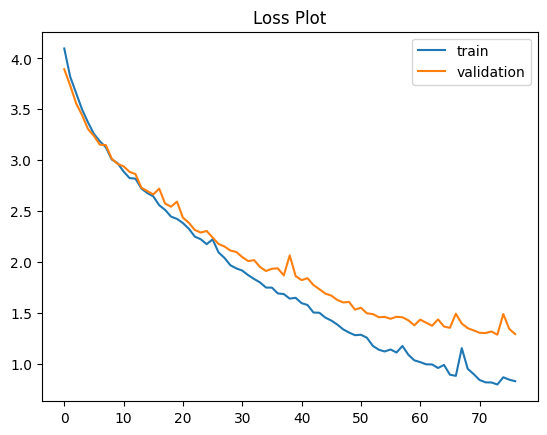

In [ ]:
# Plot the loss
plt.title('Loss Plot')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

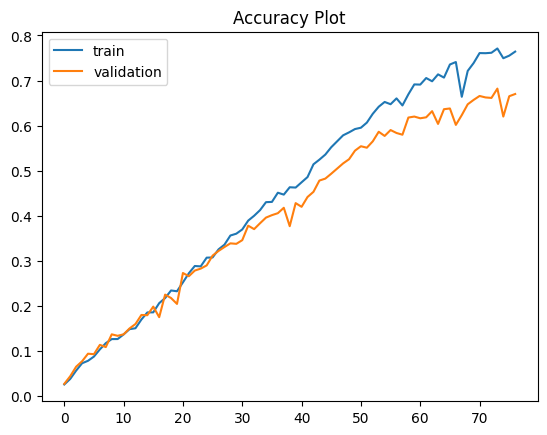

In [ ]:
# Plot the accuracy
plt.title('Accuracy Plot')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.show()

In [ ]:
# Load the saved model
saved_model = tf.keras.models.load_model(model_checkpoint_path)

# Evaluate the model with the test set
loss, accuracy = saved_model.evaluate(X_test_padded, y_test_array)

print("Test Loss:", loss)
print("Test Accuracy:", round((accuracy*100), 2))

97/97 [==============================] - 2s 7ms/step - loss: 1.2908 - accuracy: 0.6769
Test Loss: 1.2908092737197876
Test Accuracy: 67.69


In [ ]:
# Check predictions with the test set
y_test_prob = saved_model.predict(X_test_padded)

# Convert probabilities to class labels
y_test_pred = np.argmax(y_test_prob, axis=1)

# Calculate precision, recall, and f1 score
precision = precision_score(y_test_array, y_test_pred, average='weighted')
recall = recall_score(y_test_array, y_test_pred, average='weighted')
f1 = f1_score(y_test_array, y_test_pred, average='weighted')

print("Precision:", round((precision*100), 2))
print("Recall:", round((recall*100), 2))
print("F1 Score:", round((f1*100), 2))

97/97 [==============================] - 2s 9ms/step
Precision: 67.88
Recall: 67.69
F1 Score: 66.03


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Error analysis

# Print classification report
print(classification_report(y_test_array, y_test_pred))

# Check misclassified data
misclassified_data = np.where(y_test_pred != y_test_array)[0]
print(f"The number of misclassifications: {len(misclassified_data)}")

# Check the ratio of misclassifications
misclassification_ratio = (len(misclassified_data) / len(y_test_array)) * 100
# Round the number
rounded_ratio = round(misclassification_ratio, 2)
print(f"Proportion of misclassifications: {rounded_ratio}%")

# Iterate over misclassified data for error analysis
for idx in misclassified_data[:30]:
    input_text = X_test[idx]
    true_label = y_test[idx]
    predicted_label = y_test_pred[idx]

    # Print information about the misclassified data
    print("Input Text:", input_text)
    print("Actual Label:", true_label)
    print("Predicted Label:", predicted_label)
    print()

              precision    recall  f1-score   support

           0       0.87      0.85      0.86        40
           1       0.90      0.95      0.93        40
           2       0.97      0.97      0.97        40
           3       0.79      0.65      0.71        40
           4       0.77      0.68      0.72        40
           5       0.46      0.68      0.55        40
           6       0.80      0.90      0.85        40
           7       0.62      0.45      0.52        40
           8       0.71      0.85      0.77        40
           9       0.90      0.93      0.91        40
          10       0.50      0.05      0.09        40
          11       0.45      0.75      0.57        40
          12       0.64      0.17      0.27        40
          13       0.74      0.80      0.77        40
          14       0.37      0.55      0.44        40
          15       0.74      0.80      0.77        40
          16       0.64      0.62      0.63        40
          17       0.85    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### LSTM (with dropout)

In [ ]:
# Define the output dimension for the embedding layer and hidden units
hidden_unit = 30
nlabel = 77

dropout_model = keras.models.Sequential()
e = layers.Embedding(voca_size+1, 100, weights=[embedding_matrix], input_length=max_length_train_text, trainable=False) # Using 100 dimension for GloVe
dropout_model.add(e)
dropout_model.add(layers.LSTM(hidden_unit, dropout=0.2))
dropout_model.add(layers.Dense(nlabel, activation='softmax'))

# Compile the model
dropout_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy']) #, run_eagerly=True

# Summary the model
dropout_model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 29, 100)           208900    
                                                                 
 lstm_11 (LSTM)              (None, 30)                15720     
                                                                 
 dense_11 (Dense)            (None, 77)                2387      
                                                                 
Total params: 227007 (886.75 KB)
Trainable params: 18107 (70.73 KB)
Non-trainable params: 208900 (816.02 KB)
_________________________________________________________________


In [ ]:
# Define the folder path to save the model
folder_path = '/content/drive/MyDrive/Colab Notebooks/Classifying Bank Customer Service Questions/models/LSTM/'

# Define the file path for the model checkpoint
model_checkpoint_path = folder_path + 'dropout_LSTM_glove_model.keras'

# Define the model checkpoint
mc = tf.keras.callbacks.ModelCheckpoint(
    filepath=model_checkpoint_path,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
# Import time to measure the elapsed time
import time

# Measure time before training
start_time = time.time()

# Fit the model
history = dropout_model.fit(
    X_train_padded, y_train,
    epochs = 100,
    validation_data = (X_val_padded, y_val),
    callbacks = [mc, es],
    batch_size = 32)

# End the training time
end_time = time.time()

# Measure the training time
training_time = end_time - start_time
print("Training time:", training_time, "seconds")

Epoch 1/100
230/230 [==============================] - 9s 25ms/step - loss: 4.1219 - accuracy: 0.0373 - val_loss: 3.7914 - val_accuracy: 0.0572
Epoch 2/100
230/230 [==============================] - 4s 20ms/step - loss: 3.6903 - accuracy: 0.0694 - val_loss: 3.5403 - val_accuracy: 0.0925
Epoch 3/100
230/230 [==============================] - 6s 28ms/step - loss: 3.4460 - accuracy: 0.1055 - val_loss: 3.2752 - val_accuracy: 0.1285
Epoch 4/100
230/230 [==============================] - 5s 20ms/step - loss: 3.2353 - accuracy: 0.1286 - val_loss: 3.0684 - val_accuracy: 0.1671
Epoch 5/100
230/230 [==============================] - 5s 20ms/step - loss: 3.0482 - accuracy: 0.1516 - val_loss: 2.8333 - val_accuracy: 0.2047
Epoch 6/100
230/230 [==============================] - 7s 29ms/step - loss: 2.8758 - accuracy: 0.1838 - val_loss: 2.6965 - val_accuracy: 0.2384
Epoch 7/100
230/230 [==============================] - 4s 19ms/step - loss: 2.7410 - accuracy: 0.2053 - val_loss: 2.5757 - val_accuracy:

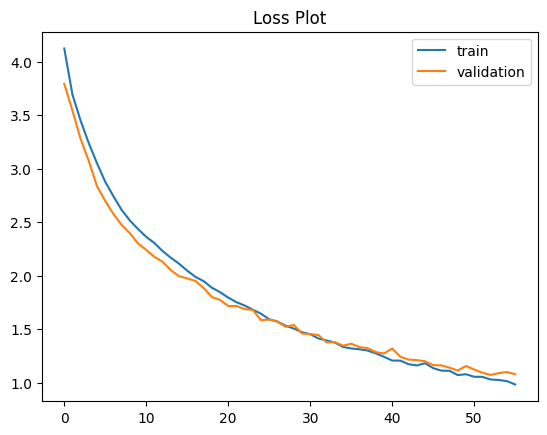

In [ ]:
# Plot the loss
plt.title('Loss Plot')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

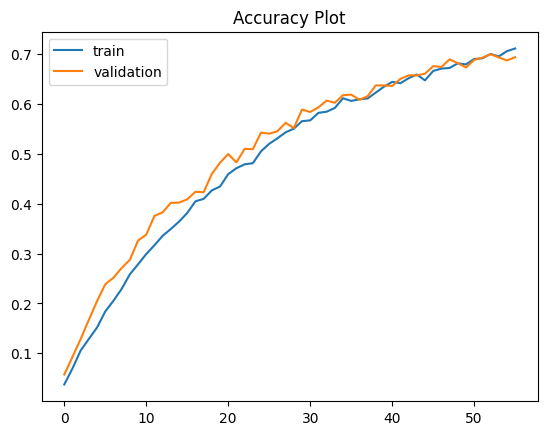

In [ ]:
# Plot the accuracy
plt.title('Accuracy Plot')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.show()

In [ ]:
# Load the saved model
saved_model = tf.keras.models.load_model(model_checkpoint_path)

# Evaluate the model with the test set
loss, accuracy = saved_model.evaluate(X_test_padded, y_test_array)

print("Test Loss:", loss)
print("Test Accuracy:", round((accuracy*100), 2))

97/97 [==============================] - 2s 6ms/step - loss: 1.0427 - accuracy: 0.7166
Test Loss: 1.042669415473938
Test Accuracy: 71.66


In [ ]:
# Check predictions with the test set
y_test_prob = saved_model.predict(X_test_padded)

# Convert probabilities to class labels
y_test_pred = np.argmax(y_test_prob, axis=1)

# Calculate precision, recall, and f1 score
precision = precision_score(y_test_array, y_test_pred, average='weighted')
recall = recall_score(y_test_array, y_test_pred, average='weighted')
f1 = f1_score(y_test_array, y_test_pred, average='weighted')

print("Precision:", round((precision*100), 2))
print("Recall:", round((recall*100), 2))
print("F1 Score:", round((f1*100), 2))

97/97 [==============================] - 1s 7ms/step
Precision: 72.08
Recall: 71.66
F1 Score: 70.69


In [ ]:
# Error analysis

# Print classification report
print(classification_report(y_test_array, y_test_pred))

# Check misclassified data
misclassified_data = np.where(y_test_pred != y_test_array)[0]
print(f"The number of misclassifications: {len(misclassified_data)}")

# Check the ratio of misclassifications
misclassification_ratio = (len(misclassified_data) / len(y_test_array)) * 100
# Round the number
rounded_ratio = round(misclassification_ratio, 2)
print(f"Proportion of misclassifications: {rounded_ratio}%")

# Iterate over misclassified data for error analysis
for idx in misclassified_data[:30]:
    input_text = X_test[idx]
    true_label = y_test[idx]
    predicted_label = y_test_pred[idx]

    # Print information about the misclassified data
    print("Input Text:", input_text)
    print("Actual Label:", true_label)
    print("Predicted Label:", predicted_label)
    print()

              precision    recall  f1-score   support

           0       0.92      0.90      0.91        40
           1       0.77      0.85      0.81        40
           2       0.86      0.95      0.90        40
           3       0.82      0.70      0.76        40
           4       0.66      0.68      0.67        40
           5       0.59      0.75      0.66        40
           6       0.85      0.85      0.85        40
           7       0.79      0.47      0.59        40
           8       0.77      0.82      0.80        40
           9       1.00      0.93      0.96        40
          10       0.00      0.00      0.00        40
          11       0.41      0.82      0.55        40
          12       0.58      0.35      0.44        40
          13       0.80      0.88      0.83        40
          14       0.66      0.68      0.67        40
          15       0.74      0.78      0.76        40
          16       0.52      0.62      0.57        40
          17       0.94    

### Hyperparameter tuning

In [ ]:
# The code for hyperparameter tuning is derived from the Tensorflow website.
# (https://www.tensorflow.org/tutorials/keras/keras_tuner)

# Define the model for hyperparameter tuning
def model_builder(hp):
  model = keras.models.Sequential()
  e = layers.Embedding(voca_size+1, 100, weights=[embedding_matrix], input_length=max_length_train_text, trainable=False)
  model.add(e)
  hp_units = hp.Int('units', min_value = 20, max_value = 50, step = 10) # Set up the hyperparameters
  model.add(layers.LSTM(units = hp_units)) # We will check the optimal hidden unit for the LSTM layer
  model.add(layers.Dense(nlabel, activation='softmax'))

  hp_learning_rate = hp.Choice('learning_rate', values = [0.01, 0.001, 0.0001]) # Set up the hyperparameters
  model.compile(optimizer = keras.optimizers.Adam(learning_rate = hp_learning_rate), # We will check the optimal learning rate
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  return model

In [ ]:
# The code for hyperparameter tuning is derived from the Tensorflow website.
# (https://www.tensorflow.org/tutorials/keras/keras_tuner)

# Specify the tuner
tuner = kt.Hyperband(model_builder,
                     objective = 'val_accuracy',
                     max_epochs = 100)

In [ ]:
# The code for hyperparameter tuning is derived from the Tensorflow website.
# (https://www.tensorflow.org/tutorials/keras/keras_tuner)

# Set up a callback for early stopping
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
# The code for hyperparameter tuning is derived from the Tensorflow website.
# (https://www.tensorflow.org/tutorials/keras/keras_tuner)

# Run the tuner
tuner.search(X_train_padded, y_train, epochs = 100, validation_data = (X_val_padded, y_val), callbacks = [stop_early])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"The optimal number of units: {best_hps.get('units')}. The optimal learning rate: {best_hps.get('learning_rate')}.")

Trial 12 Complete [00h 00m 13s]
val_accuracy: 0.02994011901319027

Best val_accuracy So Far: 0.2449646145105362
Total elapsed time: 00h 09m 37s
The optimal number of units: 50. The optimal learning rate: 0.01.


### Tuned LSTM

In [ ]:
# Define the output dimension for the embedding layer and hidden units
nlabel = 77

tuned_model = keras.models.Sequential()
e = layers.Embedding(voca_size+1, 100, weights=[embedding_matrix], input_length=max_length_train_text, trainable=False) # Using 100 dimension for GloVe
tuned_model.add(e)
tuned_model.add(layers.LSTM(50))
tuned_model.add(layers.Dense(nlabel, activation='softmax'))

# Compile the model
tuned_model.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy']) #, run_eagerly=True

# Summary the model
tuned_model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 29, 100)           208900    
                                                                 
 lstm_12 (LSTM)              (None, 50)                30200     
                                                                 
 dense_12 (Dense)            (None, 77)                3927      
                                                                 
Total params: 243027 (949.32 KB)
Trainable params: 34127 (133.31 KB)
Non-trainable params: 208900 (816.02 KB)
_________________________________________________________________


In [ ]:
# Define the folder path to save the model
folder_path = '/content/drive/MyDrive/Colab Notebooks/Classifying Bank Customer Service Questions/models/LSTM/'

# Define the file path for the model checkpoint
model_checkpoint_path = folder_path + 'tuned_LSTM_glove_model.keras'

# Define the model checkpoint
mc = tf.keras.callbacks.ModelCheckpoint(
    filepath=model_checkpoint_path,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
# Import time to measure the elapsed time
import time

# Measure time before training
start_time = time.time()

# Fit the model
history = tuned_model.fit(
    X_train_padded, y_train,
    epochs = 100,
    validation_data = (X_val_padded, y_val),
    callbacks = [mc, es],
    batch_size = 32)

# End the training time
end_time = time.time()

# Measure the training time
training_time = end_time - start_time
print("Training time:", training_time, "seconds")

Epoch 1/100
230/230 [==============================] - 10s 34ms/step - loss: 3.7835 - accuracy: 0.0475 - val_loss: 3.2911 - val_accuracy: 0.1083
Epoch 2/100
230/230 [==============================] - 5s 22ms/step - loss: 3.0044 - accuracy: 0.1673 - val_loss: 2.4936 - val_accuracy: 0.2450
Epoch 3/100
230/230 [==============================] - 5s 21ms/step - loss: 2.2075 - accuracy: 0.3361 - val_loss: 1.9810 - val_accuracy: 0.3865
Epoch 4/100
230/230 [==============================] - 8s 33ms/step - loss: 1.6925 - accuracy: 0.4758 - val_loss: 1.5815 - val_accuracy: 0.5248
Epoch 5/100
230/230 [==============================] - 5s 20ms/step - loss: 1.4416 - accuracy: 0.5687 - val_loss: 1.5846 - val_accuracy: 0.5416
Epoch 6/100
230/230 [==============================] - 5s 21ms/step - loss: 1.2428 - accuracy: 0.6352 - val_loss: 1.2479 - val_accuracy: 0.6375
Epoch 7/100
230/230 [==============================] - 7s 30ms/step - loss: 1.0417 - accuracy: 0.6911 - val_loss: 1.2065 - val_accuracy

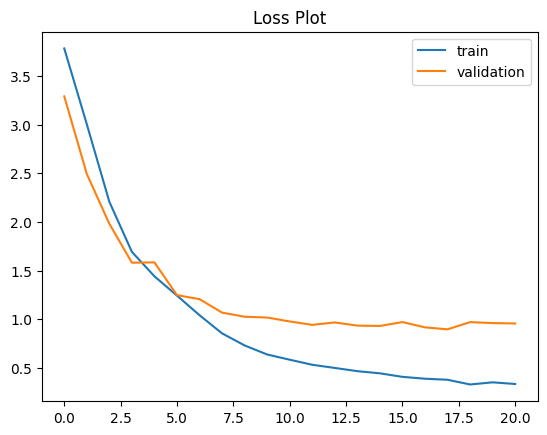

In [ ]:
# Plot the loss
plt.title('Loss Plot')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

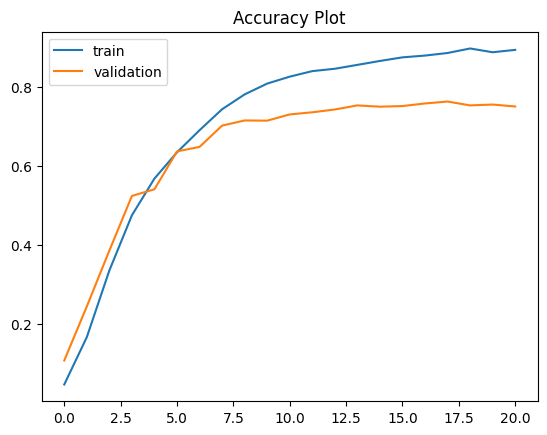

In [ ]:
# Plot the accuracy
plt.title('Accuracy Plot')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.show()

In [ ]:
# Load the saved model
saved_model = tf.keras.models.load_model(model_checkpoint_path)

# Evaluate the model with the test set
loss, accuracy = saved_model.evaluate(X_test_padded, y_test_array)

print("Test Loss:", loss)
print("Test Accuracy:", round((accuracy*100), 2))

97/97 [==============================] - 2s 7ms/step - loss: 0.8815 - accuracy: 0.7769
Test Loss: 0.8814808130264282
Test Accuracy: 77.69


In [ ]:
# Check predictions with the test set
y_test_prob = saved_model.predict(X_test_padded)

# Convert probabilities to class labels
y_test_pred = np.argmax(y_test_prob, axis=1)

# Calculate precision, recall, and f1 score
precision = precision_score(y_test_array, y_test_pred, average='weighted')
recall = recall_score(y_test_array, y_test_pred, average='weighted')
f1 = f1_score(y_test_array, y_test_pred, average='weighted')

print("Precision:", round((precision*100), 2))
print("Recall:", round((recall*100), 2))
print("F1 Score:", round((f1*100), 2))

97/97 [==============================] - 1s 7ms/step
Precision: 79.27
Recall: 77.69
F1 Score: 77.84


In [ ]:
# Error analysis

# Print classification report
print(classification_report(y_test_array, y_test_pred))

# Check misclassified data
misclassified_data = np.where(y_test_pred != y_test_array)[0]
print(f"The number of misclassifications: {len(misclassified_data)}")

# Check the ratio of misclassifications
misclassification_ratio = (len(misclassified_data) / len(y_test_array)) * 100
# Round the number
rounded_ratio = round(misclassification_ratio, 2)
print(f"Proportion of misclassifications: {rounded_ratio}%")

# Iterate over misclassified data for error analysis
for idx in misclassified_data[:30]:
    input_text = X_test[idx]
    true_label = y_test[idx]
    predicted_label = y_test_pred[idx]

    # Print information about the misclassified data
    print("Input Text:", input_text)
    print("Actual Label:", true_label)
    print("Predicted Label:", predicted_label)
    print()

              precision    recall  f1-score   support

           0       1.00      0.93      0.96        40
           1       0.92      0.88      0.90        40
           2       0.95      0.90      0.92        40
           3       0.95      0.88      0.91        40
           4       0.91      0.78      0.84        40
           5       0.56      0.68      0.61        40
           6       0.84      0.80      0.82        40
           7       0.63      0.55      0.59        40
           8       0.85      0.88      0.86        40
           9       0.95      0.97      0.96        40
          10       0.76      0.70      0.73        40
          11       0.54      0.88      0.67        40
          12       0.69      0.50      0.58        40
          13       0.81      0.95      0.87        40
          14       0.63      0.78      0.70        40
          15       0.79      0.82      0.80        40
          16       0.55      0.68      0.61        40
          17       0.84    

### Tuned LSTM (with dropout)

In [ ]:
# Define the output dimension for the embedding layer and hidden units
nlabel = 77

dropout_tuned_model = keras.models.Sequential()
e = layers.Embedding(voca_size+1, 100, weights=[embedding_matrix], input_length=max_length_train_text, trainable=False) # Using 100 dimension for GloVe
dropout_tuned_model.add(e)
dropout_tuned_model.add(layers.LSTM(50, dropout=0.2))
dropout_tuned_model.add(layers.Dense(nlabel, activation='softmax'))

# Compile the model
dropout_tuned_model.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy']) #, run_eagerly=True

# Summary the model
dropout_tuned_model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 29, 100)           208900    
                                                                 
 lstm_13 (LSTM)              (None, 50)                30200     
                                                                 
 dense_13 (Dense)            (None, 77)                3927      
                                                                 
Total params: 243027 (949.32 KB)
Trainable params: 34127 (133.31 KB)
Non-trainable params: 208900 (816.02 KB)
_________________________________________________________________


In [ ]:
# Define the folder path to save the model
folder_path = '/content/drive/MyDrive/Colab Notebooks/Classifying Bank Customer Service Questions/models/LSTM/'

# Define the file path for the model checkpoint
model_checkpoint_path = folder_path + 'dropout_tuned_LSTM_glove_model.keras'

# Define the model checkpoint
mc = tf.keras.callbacks.ModelCheckpoint(
    filepath=model_checkpoint_path,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
# Import time to measure the elapsed time
import time

# Measure time before training
start_time = time.time()

# Fit the model
history = dropout_tuned_model.fit(
    X_train_padded, y_train,
    epochs = 100,
    validation_data = (X_val_padded, y_val),
    callbacks = [mc, es],
    batch_size = 32)

# End the training time
end_time = time.time()

# Measure the training time
training_time = end_time - start_time
print("Training time:", training_time, "seconds")

Epoch 1/100
230/230 [==============================] - 11s 32ms/step - loss: 3.9919 - accuracy: 0.0328 - val_loss: 3.5665 - val_accuracy: 0.0675
Epoch 2/100
230/230 [==============================] - 5s 23ms/step - loss: 3.1440 - accuracy: 0.1525 - val_loss: 2.5732 - val_accuracy: 0.2580
Epoch 3/100
230/230 [==============================] - 7s 32ms/step - loss: 2.2885 - accuracy: 0.3294 - val_loss: 1.9406 - val_accuracy: 0.4066
Epoch 4/100
230/230 [==============================] - 5s 23ms/step - loss: 1.8043 - accuracy: 0.4413 - val_loss: 1.5322 - val_accuracy: 0.5291
Epoch 5/100
230/230 [==============================] - 6s 25ms/step - loss: 1.5087 - accuracy: 0.5449 - val_loss: 1.3131 - val_accuracy: 0.6091
Epoch 6/100
230/230 [==============================] - 6s 26ms/step - loss: 1.2901 - accuracy: 0.6024 - val_loss: 1.2017 - val_accuracy: 0.6358
Epoch 7/100
230/230 [==============================] - 5s 22ms/step - loss: 1.1630 - accuracy: 0.6401 - val_loss: 1.0661 - val_accuracy

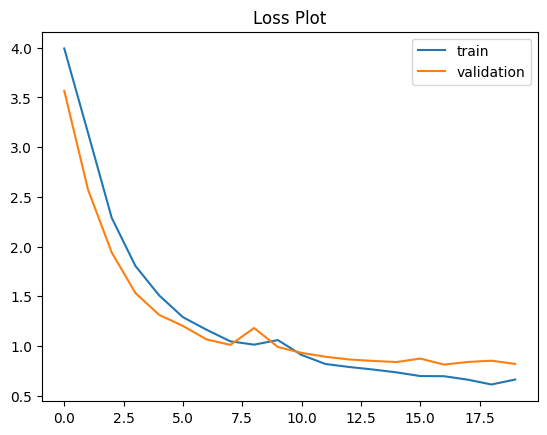

In [ ]:
# Plot the loss
plt.title('Loss Plot')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

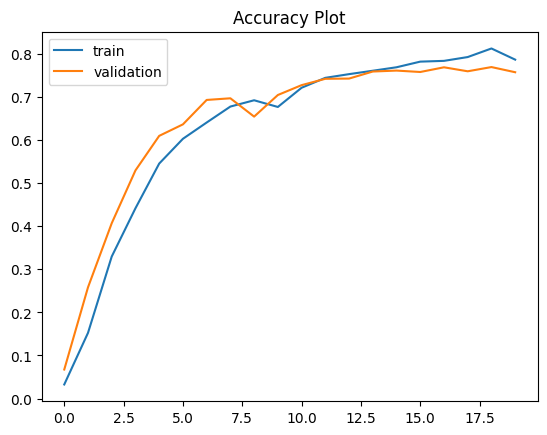

In [ ]:
# Plot the accuracy
plt.title('Accuracy Plot')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.show()

In [ ]:
# Load the saved model
saved_model = tf.keras.models.load_model(model_checkpoint_path)

# Evaluate the model with the test set
loss, accuracy = saved_model.evaluate(X_test_padded, y_test_array)

print("Test Loss:", loss)
print("Test Accuracy:", round((accuracy*100), 2))

97/97 [==============================] - 2s 8ms/step - loss: 0.7693 - accuracy: 0.7786
Test Loss: 0.7692508697509766
Test Accuracy: 77.86


In [ ]:
# Check predictions with the test set
y_test_prob = saved_model.predict(X_test_padded)

# Convert probabilities to class labels
y_test_pred = np.argmax(y_test_prob, axis=1)

# Calculate precision, recall, and f1 score
precision = precision_score(y_test_array, y_test_pred, average='weighted')
recall = recall_score(y_test_array, y_test_pred, average='weighted')
f1 = f1_score(y_test_array, y_test_pred, average='weighted')

print("Precision:", round((precision*100), 2))
print("Recall:", round((recall*100), 2))
print("F1 Score:", round((f1*100), 2))

97/97 [==============================] - 2s 11ms/step
Precision: 79.88
Recall: 77.86
F1 Score: 77.85


In [ ]:
# Error analysis

# Print classification report
print(classification_report(y_test_array, y_test_pred))

# Check misclassified data
misclassified_data = np.where(y_test_pred != y_test_array)[0]
print(f"The number of misclassifications: {len(misclassified_data)}")

# Check the ratio of misclassifications
misclassification_ratio = (len(misclassified_data) / len(y_test_array)) * 100
# Round the number
rounded_ratio = round(misclassification_ratio, 2)
print(f"Proportion of misclassifications: {rounded_ratio}%")

# Iterate over misclassified data for error analysis
for idx in misclassified_data[:30]:
    input_text = X_test[idx]
    true_label = y_test[idx]
    predicted_label = y_test_pred[idx]

    # Print information about the misclassified data
    print("Input Text:", input_text)
    print("Actual Label:", true_label)
    print("Predicted Label:", predicted_label)
    print()

              precision    recall  f1-score   support

           0       0.97      0.95      0.96        40
           1       0.89      0.97      0.93        40
           2       0.93      0.97      0.95        40
           3       0.76      0.95      0.84        40
           4       0.91      0.78      0.84        40
           5       0.48      0.75      0.59        40
           6       0.83      0.85      0.84        40
           7       0.76      0.70      0.73        40
           8       0.88      0.88      0.88        40
           9       1.00      0.90      0.95        40
          10       0.77      0.82      0.80        40
          11       0.79      0.68      0.73        40
          12       0.62      0.88      0.73        40
          13       0.90      0.88      0.89        40
          14       0.76      0.85      0.80        40
          15       0.88      0.88      0.88        40
          16       0.72      0.65      0.68        40
          17       0.77    

## Tokenize the text in the dataset

### For DistilBERT Model

#### ver. 1) Use the preprocessed dataset

In [ ]:
# Change the format as dataframe
banking77_preprocessed.reset_format()

In [ ]:
# Perform train-test split to make a validation set
# Export only data set to split (training 80%, validation 20% from the training set)
dataset_dict = banking77_preprocessed['train'].train_test_split(test_size=0.2)

In [ ]:
# Change the name 'test' to 'validation'
dataset_dict['validation'] = dataset_dict.pop('test')

In [ ]:
# Check the dataset dictionary
dataset_dict

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 8002
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2001
    })
})

In [ ]:
# Define training, validation and test sets
trainset = dataset_dict['train']
valset = dataset_dict['validation']
testset = banking77_preprocessed['test']

In [ ]:
# Change the format as dataframe to save the test set
banking77_preprocessed.set_format(type='pandas')

In [ ]:
# Define a dataframe for the test set
test_df = banking77_preprocessed['test'][:]

In [ ]:
# Specify the test set file path
csv_file_path = "/content/drive/MyDrive/Datasets/Banking77/testset.csv"

# Save the DataFrame as CSV
test_df.to_csv(csv_file_path, index=False)

In [ ]:
# Check the number of data points
pprint(len(trainset))
pprint(len(valset))
pprint(len(testset))

8002
2001
3080


In [ ]:
# This code is derived from lab tutorial 8
# Import libraries
from transformers import DistilBertTokenizer

# Tokenization
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
# This code is derived from lab tutorial 8
# Tokenize the data
def tokenize(batch):
    return tokenizer(batch['text'], padding='max_length', truncation=True, max_length=29) # Define the maximum length as 29

train_set = dataset_dict['train'].map(tokenize, batched=True)
val_set = dataset_dict['validation'].map(tokenize, batched=True)
test_set = banking77_preprocessed['test'].map(tokenize, batched=True)

Map:   0%|          | 0/8002 [00:00<?, ? examples/s]

Map:   0%|          | 0/2001 [00:00<?, ? examples/s]

Map:   0%|          | 0/3080 [00:00<?, ? examples/s]

In [ ]:
# Check the inside of test set
pprint(test_set[:1], sort_dicts=False)

{'text': ['locate card'],
 'label': [11],
 'input_ids': [[101,
                12453,
                4003,
                102,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0,
                0]],
 'attention_mask': [[1,
                     1,
                     1,
                     1,
                     0,
                     0,
                     0,
                     0,
                     0,
                     0,
                     0,
                     0,
                     0,
                     0,
                     0,
                     0,
          

In [ ]:
# This code is derived from lab tutorial 8
# Set the data format
train_set.set_format('pt', columns=['input_ids', 'attention_mask', 'label'])
val_set.set_format('pt', columns=['input_ids', 'attention_mask', 'label'])
test_set.set_format('pt', columns=['input_ids', 'attention_mask', 'label'])

In [ ]:
# Check the datatype of the training set and test set
pprint(train_set[:1])
pprint(val_set[:1])
pprint(test_set[:1])

{'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0]]),
 'input_ids': tensor([[  101,  5356,  2134,  2102,  2131,  3065, 10439,   102,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0]]),
 'label': tensor([20])}
{'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0]]),
 'input_ids': tensor([[  101,  3841, 12879, 24108,  2854, 23439,   102,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0]]),
 'label': tensor([7])}
{'attention_mask': tensor([[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0]]),
 'input_ids': tensor([[  101, 12453,  4003,   102,     0,     0,     0,     0,

#### DistilBERT

In [ ]:
# Import libraries
import torch
import torch.nn as nn

# Check the run time
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
# This code is derived from lab tutorial 8
from transformers import DistilBertModel

model = DistilBertModel.from_pretrained('distilbert-base-uncased')

In [ ]:
# This code is derived from lab tutorial 8
# Define the model architecture
class DistilBERT(nn.Module):
    def __init__(self, model):
        super(DistilBERT, self).__init__()
        self.model = model
        self.linear = nn.Linear(768, 77) # 77 classes

    def forward(self, input_ids, attention_mask):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.last_hidden_state[:, 0, :]
        logits = self.linear(last_hidden_state)
        return logits

# Define the model
model = DistilBERT(model)
model.to(device)

DistilBERT(
  (model): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(in_f

In [ ]:
# This code is derived from lab tutorial 8
# Set up the optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
# Set up the data loader for each dataset
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=False)

In [ ]:
# Import the library to save the test set for the distilBERT model
import os

# Define the save function for test loader
def save_test_data(test_loader, save_dir):
    for i, batch in enumerate(test_loader):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['label']
        # Save each batch of data
        torch.save((input_ids, attention_mask, labels), os.path.join(save_dir, f"test_batch_{i}.pt"))

# Specify the directory to save test data
save_dir = "/content/drive/MyDrive/Colab Notebooks/Classifying Bank Customer Service Questions/models/DistilBERT"
save_test_data(test_loader, save_dir)

In [ ]:
# Define the folder path to save the state dictionary
folder_path = '/content/drive/MyDrive/Colab Notebooks/Classifying Bank Customer Service Questions/models/DistilBERT'

# Define the dictionary file path for the model checkpoint
model_save_path = folder_path + 'distilBERT_model.pth'

In [ ]:
#Free up GPU memory
torch.cuda.empty_cache()

In [ ]:
# Define the train function
# Import time to measure the training time
import time

def train_and_evaluate(model, train_loader, val_loader, optimizer, loss_fn, device, model_save_path):
    train_losses, val_losses = [], [] # Empty lists to store losses
    train_accuracies, val_accuracies = [], [] # Empty lists to store accuracies

    # Measure the total training time
    total_start_time = time.time()

    for epoch in range(5):
        # Training
        start_time = time.time() # Measure each training time
        model.train()

        epoch_train_loss = 0.0
        correct_train, total_train = 0, 0

        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item() * input_ids.size(0) # Check the train loss per epoch

            predictions_train = torch.round(torch.softmax(outputs, dim=1))
            predicted_train = torch.argmax(predictions_train, dim=1)
            total_train += labels.size(0)
            correct_train += (predicted_train == labels).sum().item()

        train_loss = epoch_train_loss / len(train_loader.dataset)
        train_accuracy = correct_train / total_train
        train_losses.append(train_loss) # Total train loss
        train_accuracies.append(train_accuracy)

        # Validation
        model.eval()
        correct_val, total_val = 0, 0
        epoch_val_loss = 0.0

        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['label'].to(device)

                outputs = model(input_ids, attention_mask)
                predictions_val = torch.round(torch.softmax(outputs, dim=1))
                predicted_val = torch.argmax(predictions_val, dim=1)

                loss_val = loss_fn(outputs, labels)
                epoch_val_loss += loss_val.item() * input_ids.size(0) # Check the validation loss per epoch

                total_val += labels.size(0)
                correct_val += (predicted_val == labels).sum().item()

        val_loss = epoch_val_loss / len(val_loader.dataset)
        val_accuracy = correct_val / total_val
        val_losses.append(val_loss) # Total validation loss
        val_accuracies.append(val_accuracy)

        end_time = time.time()
        each_train_duration = end_time - start_time

        # Add 1 to epoch as it starts from 0
        print(f'Epoch {epoch+1} - Training Time: {each_train_duration:.3f} seconds, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

    total_end_time = time.time()
    total_train_duration = end_time - start_time
    print(f'Total training time: {total_train_duration:.3f} seconds')

    # Save the state dictionary
    torch.save(model.state_dict(), model_save_path)
    # Define the file name and path to save the model itself
    # This saving model code is derived from the tutorial of Huggingface's DistilBERT (A notebook on how to finetune DistilBERT for multiclass classification with PyTorch)
    # (https://huggingface.co/docs/transformers/en/model_doc/distilbert#transformers.DistilBertConfig)
    output_model_file = '/content/drive/MyDrive/Colab Notebooks/Classifying Bank Customer Service Questions/models/DistilBERT/processed_distilbert.bin'
    model_to_save = model
    # Save the model itself
    torch.save(model_to_save, output_model_file)
    print('Model and state dictionary have been saved')

    return train_losses, val_losses, train_accuracies, val_accuracies

In [ ]:
# Train the model
train_losses, val_losses, train_accuracies, val_accuracies = train_and_evaluate(model, train_loader, val_loader, optimizer, loss_fn, device, model_save_path)

Epoch 1 - Training Time: 24.662 seconds, Train Loss: 2.8097, Train Accuracy: 0.0452, Validation Loss: 1.3046, Validation Accuracy: 0.3323
Epoch 2 - Training Time: 23.877 seconds, Train Loss: 1.0237, Train Accuracy: 0.4834, Validation Loss: 0.7290, Validation Accuracy: 0.7026
Epoch 3 - Training Time: 24.640 seconds, Train Loss: 0.5813, Train Accuracy: 0.7652, Validation Loss: 0.5454, Validation Accuracy: 0.8086
Epoch 4 - Training Time: 24.036 seconds, Train Loss: 0.3852, Train Accuracy: 0.8585, Validation Loss: 0.4629, Validation Accuracy: 0.8471
Epoch 5 - Training Time: 24.423 seconds, Train Loss: 0.2616, Train Accuracy: 0.9136, Validation Loss: 0.4399, Validation Accuracy: 0.8576
Total training time: 24.423 seconds
Model and state dictionary have been saved


In [ ]:
# Plot the loss and accuracy
# Define the plot fuction
def plot_training_curve(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1) # Add 1 to the length of the list as the epoch starts from 0

    plt.figure(figsize=(12, 8))

    # Plot training and validation losses
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Training Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

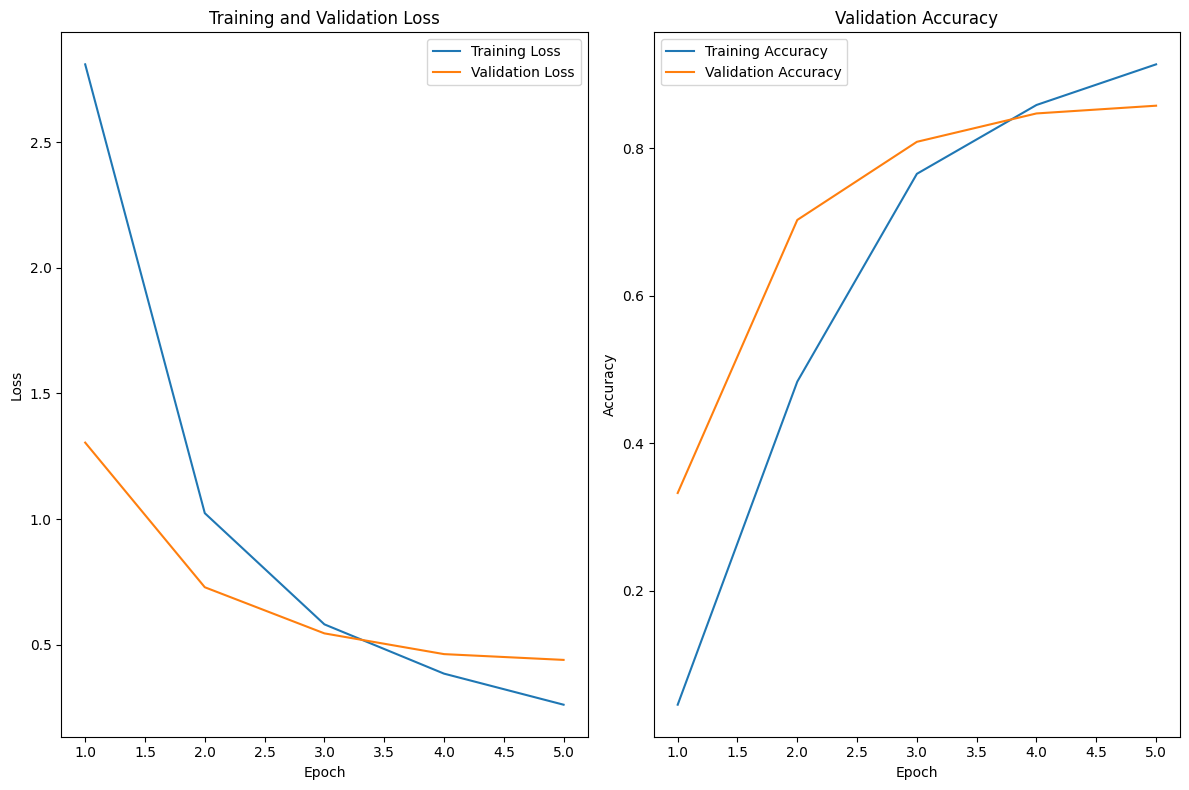

In [ ]:
# Plot the loss and accuracy of train and validation
plot_training_curve(train_losses, val_losses, train_accuracies, val_accuracies)

In [ ]:
# Load the model to test
test_model = torch.load('/content/drive/MyDrive/Colab Notebooks/Classifying Bank Customer Service Questions/models/DistilBERT/processed_distilbert.bin', map_location=torch.device('cpu'))
# Match the state dictionary to the loaded model
state_dict = torch.load(model_save_path, map_location=torch.device('cpu'))
test_model.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
# Define the test function
def evaluate(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    predictions_list = []
    labels_list = []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']
            labels = batch['label']

            outputs = model(input_ids, attention_mask)
            predictions = torch.argmax(outputs, dim=1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

            predictions_list.extend(predictions.cpu().numpy()) # Make sure it will run in CPU
            labels_list.extend(labels.cpu().numpy()) # Make sure it will run in CPU

    accuracy = correct / total
    precision = precision_score(labels_list, predictions_list, average='weighted')
    recall = recall_score(labels_list, predictions_list, average='weighted')
    f1 = f1_score(labels_list, predictions_list, average='weighted')

    return accuracy, precision, recall, f1

In [ ]:
# Test the model
test_model.eval()

# Get the test accuracy
test_accuracy, test_precision, test_recall, test_f1 = evaluate(test_model, test_loader)

print(f'Test Accuracy: {round((test_accuracy*100), 2)}')
print(f'Test Precision: {round((test_precision*100), 2)}')
print(f'Test Recall: {round((test_recall*100), 2)}')
print(f'Test F1 Score: {round((test_f1*100), 2)}')

Test Accuracy: 89.55
Test Precision: 90.08
Test Recall: 89.55
Test F1 Score: 89.56


In [ ]:
# Make predictions on the test dataset
predictions = model.predict(test_set)

# Get the predicted labels
predicted_labels = [np.argmax(pred) for pred in predictions]

# Get the ground truth labels
true_labels = test_set['label']

# Initialize lists to store misclassified instances
misclassified_texts = []
misclassified_predicted_labels = []
misclassified_true_labels = []

# Compare predictions with ground truth labels
for i in range(len(true_labels)):
    if predicted_labels[i] != true_labels[i]:
        # Add misclassified instance to lists
        misclassified_texts.append(test_set['text'][i])
        misclassified_predicted_labels.append(predicted_labels[i])
        misclassified_true_labels.append(true_labels[i])

# Print some misclassified instances for analysis
for i in range(min(10, len(misclassified_texts))):
    print("Text:", misclassified_texts[i])
    print("Predicted Label:", misclassified_predicted_labels[i])
    print("True Label:", misclassified_true_labels[i])
    print()

#### ver. 2) Use the unprocessed dataset

In [ ]:
# Perform train-test split to make a validation set
# Export only data set to split (training 80%, validation 20% from the training set)
dataset_dict2 = banking77['train'].train_test_split(test_size=0.2)

In [ ]:
# Change the name 'test' to 'validation'
dataset_dict2['validation'] = dataset_dict2.pop('test')

In [ ]:
# Check the dataset dictionary
dataset_dict2

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 8002
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2001
    })
})

In [ ]:
# Define a dataframe for the test set
test_df2 = banking77['test'][:]

In [ ]:
# Check the dataframe of the test set
test_df2

,text,label
0,How do I locate my card?,11
1,"I still have not received my new card, I order...",11
2,I ordered a card but it has not arrived. Help ...,11
3,Is there a way to know when my card will arrive?,11
4,My card has not arrived yet.,11
...,...,...
3075,"If i'm not in the UK, can I still get a card?",24
3076,How many countries do you support?,24
3077,What countries do you do business in?,24
3078,What are the countries you operate in.,24


In [ ]:
# Specify the test set file path
csv_file_path = "/content/drive/MyDrive/Datasets/Banking77/testset2.csv"

# Save the DataFrame as CSV
test_df2.to_csv(csv_file_path, index=False)

In [ ]:
# Define training, validation and test sets
trainset2 = dataset_dict2['train']
valset2 = dataset_dict2['validation']
testset2 = banking77['test']

In [ ]:
# This code is derived from lab tutorial 8
# Import libraries
from transformers import DistilBertTokenizer

# Tokenization
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
# This code is derived from lab tutorial 8
# Tokenize the data
def tokenize(batch):
    return tokenizer(batch['text'], padding='max_length', truncation=True, max_length=29) # Define the maximum length as 29

train_set2 = dataset_dict2['train'].map(tokenize, batched=True)
val_set2 = dataset_dict2['validation'].map(tokenize, batched=True)
test_set2 = banking77['test'].map(tokenize, batched=True)

Map:   0%|          | 0/8002 [00:00<?, ? examples/s]

Map:   0%|          | 0/2001 [00:00<?, ? examples/s]

In [ ]:
# This code is derived from lab tutorial 8
# Set the data format
train_set2.set_format('pt', columns=['input_ids', 'attention_mask', 'label'])
val_set2.set_format('pt', columns=['input_ids', 'attention_mask', 'label'])
test_set2.set_format('pt', columns=['input_ids', 'attention_mask', 'label'])

#### DistilBERT

In [ ]:
# Import libraries
import torch
import torch.nn as nn

# Check the run time
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
# This code is derived from lab tutorial 8
from transformers import DistilBertModel

model = DistilBertModel.from_pretrained('distilbert-base-uncased')

In [ ]:
# This code is derived from lab tutorial 8
# Define the model architecture
class DistilBERT(nn.Module):
    def __init__(self, model):
        super(DistilBERT, self).__init__()
        self.model = model
        self.linear = nn.Linear(768, 77) # 77 classes

    def forward(self, input_ids, attention_mask):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.last_hidden_state[:, 0, :]
        logits = self.linear(last_hidden_state)
        return logits

# Define the model
model = DistilBERT(model)
model.to(device)

DistilBERT(
  (model): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(in_f

In [ ]:
# This code is derived from lab tutorial 8
# Set up the optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
# Set up the data loader for each dataset
train_loader2 = torch.utils.data.DataLoader(train_set2, batch_size=32, shuffle=True)
val_loader2 = torch.utils.data.DataLoader(val_set2, batch_size=32, shuffle=True)
test_loader2 = torch.utils.data.DataLoader(test_set2, batch_size=32, shuffle=False)

In [ ]:
# Define the folder path to save the state dictionary
folder_path = '/content/drive/MyDrive/Colab Notebooks/Classifying Bank Customer Service Questions/models/DistilBERT'

# Define the dictionary file path for the model checkpoint
model_save_path = folder_path + 'unprocessed_distilBERT_model.pth'

In [ ]:
#Free up GPU memory
torch.cuda.empty_cache()

In [ ]:
# Define the train function
# Import time to measure the training time
import time

def train_and_evaluate(model, train_loader, val_loader, optimizer, loss_fn, device, model_save_path):
    train_losses, val_losses = [], [] # Empty lists to store losses
    train_accuracies, val_accuracies = [], [] # Empty lists to store accuracies

    # Measure the total training time
    total_start_time = time.time()

    for epoch in range(5):
        # Training
        start_time = time.time() # Measure each training time
        model.train()

        epoch_train_loss = 0.0
        correct_train, total_train = 0, 0

        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item() * input_ids.size(0)

            predictions_train = torch.round(torch.softmax(outputs, dim=1))
            predicted_train = torch.argmax(predictions_train, dim=1)
            total_train += labels.size(0)
            correct_train += (predicted_train == labels).sum().item()

        train_loss = epoch_train_loss / len(train_loader.dataset)
        train_accuracy = correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation
        model.eval()
        correct_val, total_val = 0, 0
        epoch_val_loss = 0.0

        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['label'].to(device)

                outputs = model(input_ids, attention_mask)
                predictions_val = torch.round(torch.softmax(outputs, dim=1))
                predicted_val = torch.argmax(predictions_val, dim=1)

                loss_val = loss_fn(outputs, labels)
                epoch_val_loss += loss_val.item() * input_ids.size(0)

                total_val += labels.size(0)
                correct_val += (predicted_val == labels).sum().item()

        val_loss = epoch_val_loss / len(val_loader.dataset)
        val_accuracy = correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        end_time = time.time()
        each_train_duration = end_time - start_time

        # Add 1 to epoch as it starts from 0
        print(f'Epoch {epoch+1} - Training Time: {each_train_duration:.3f} seconds, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

    total_end_time = time.time()
    total_train_duration = end_time - start_time
    print(f'Total training time: {total_train_duration:.3f} seconds')

    # Save the state dictionary
    torch.save(model.state_dict(), model_save_path)
    # Define the file name and path to save the model itself
    # This saving model code is derived from the tutorial of Huggingface's DistilBERT (A notebook on how to finetune DistilBERT for multiclass classification with PyTorch)
    # (https://huggingface.co/docs/transformers/en/model_doc/distilbert#transformers.DistilBertConfig)
    output_model_file = '/content/drive/MyDrive/Colab Notebooks/Classifying Bank Customer Service Questions/models/DistilBERT/unprocessed_distilbert.bin'
    model_to_save = model
    # Save the model itself
    torch.save(model_to_save, output_model_file)
    print('Model and state dictionary have been saved')

    return train_losses, val_losses, train_accuracies, val_accuracies

In [ ]:
# Train the model
train_losses, val_losses, train_accuracies, val_accuracies = train_and_evaluate(model, train_loader2, val_loader2, optimizer, loss_fn, device, model_save_path)

Epoch 1 - Training Time: 24.963 seconds, Train Loss: 2.7830, Train Accuracy: 0.0427, Validation Loss: 1.2840, Validation Accuracy: 0.3243
Epoch 2 - Training Time: 25.533 seconds, Train Loss: 0.9567, Train Accuracy: 0.5292, Validation Loss: 0.6202, Validation Accuracy: 0.7576
Epoch 3 - Training Time: 23.989 seconds, Train Loss: 0.5104, Train Accuracy: 0.8082, Validation Loss: 0.4246, Validation Accuracy: 0.8546
Epoch 4 - Training Time: 24.265 seconds, Train Loss: 0.3171, Train Accuracy: 0.8967, Validation Loss: 0.3638, Validation Accuracy: 0.8801
Epoch 5 - Training Time: 24.323 seconds, Train Loss: 0.2051, Train Accuracy: 0.9405, Validation Loss: 0.3408, Validation Accuracy: 0.8831
Total training time: 24.323 seconds
Model and state dictionary have been saved


In [ ]:
# Plot the loss and accuracy
# Define the plot fuction
def plot_training_curve(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1) # Add 1 to the length of the list as the epoch starts from 0

    plt.figure(figsize=(12, 8))

    # Plot training and validation losses
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Training Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

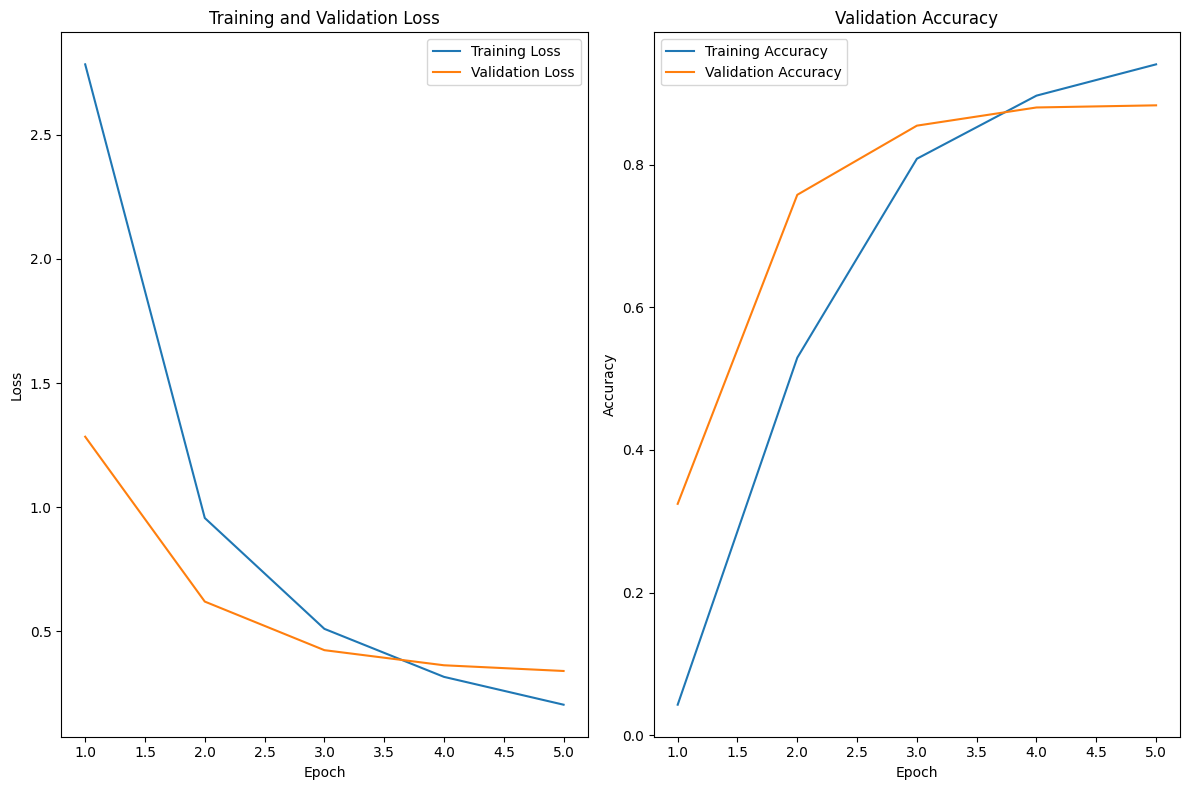

In [ ]:
# Plot the loss and accuracy of train and validation
plot_training_curve(train_losses, val_losses, train_accuracies, val_accuracies)

In [ ]:
# Load the model to test
test_model = torch.load('/content/drive/MyDrive/Colab Notebooks/Classifying Bank Customer Service Questions/models/DistilBERT/unprocessed_distilbert.bin', map_location=torch.device('cpu'))
# Match the state dictionary to the loaded model
state_dict = torch.load(model_save_path, map_location=torch.device('cpu'))
test_model.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
# Define the test function
def evaluate(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    predictions_list = []
    labels_list = []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']
            labels = batch['label']

            outputs = model(input_ids, attention_mask)
            predictions = torch.argmax(outputs, dim=1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

            predictions_list.extend(predictions.cpu().numpy()) # Make sure it will run in CPU
            labels_list.extend(labels.cpu().numpy()) # Make sure it will run in CPU

    accuracy = correct / total
    precision = precision_score(labels_list, predictions_list, average='weighted')
    recall = recall_score(labels_list, predictions_list, average='weighted')
    f1 = f1_score(labels_list, predictions_list, average='weighted')

    return accuracy, precision, recall, f1

In [ ]:
# Test the model
test_model.eval()

# Get the test accuracy
test_accuracy, test_precision, test_recall, test_f1 = evaluate(test_model, test_loader)

print(f'Test Accuracy: {round((test_accuracy*100), 2)}')
print(f'Test Precision: {round((test_precision*100), 2)}')
print(f'Test Recall: {round((test_recall*100), 2)}')
print(f'Test F1 Score: {round((test_f1*100), 2)}')

Test Accuracy: 83.28
Test Precision: 85.21
Test Recall: 83.28
Test F1 Score: 83.44


## Intermediate results

The model below does not learn properly when applying the true maximum length.

In [ ]:
# Define the maximum length as 303
true_max_length_train_text = 303
true_max_length_train_text

303

In [ ]:
# Import the library for padding
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Padding and truncation will be added to post-texts
X_train_true_padded = pad_sequences(X_train_sequences, maxlen=true_max_length_train_text, padding="post", truncating="post")
X_val_true_padded = pad_sequences(X_val_sequences, maxlen=true_max_length_train_text, padding="post", truncating="post")
X_test_true_padded = pad_sequences(X_test_sequences, maxlen=true_max_length_train_text, padding="post", truncating="post")

In [ ]:
# Check the dimension of the variables
print(X_train_true_padded.shape)
print(X_val_true_padded.shape)
print(X_test_true_padded.shape)

(7346, 303)
(1837, 303)
(3080, 303)


In [ ]:
# Check the first 3 elements of all X train variables
print(X_train_array[3])
print(X_train_sequences[3])
print(X_train_true_padded[3])

something wrong account balance didnt change transferred money
[50, 31, 2, 93, 23, 68, 127, 3]
[ 50  31   2  93  23  68 127   3   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0 

In [ ]:
# Define the output dimension for the embedding layer and hidden units
embedding_output_dim = 100
hidden_unit = 30
nlabel = 77

model = keras.models.Sequential()
model.add(layers.Embedding(voca_size, embedding_output_dim))
model.add(layers.LSTM(hidden_unit))
model.add(layers.Dense(nlabel, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy']) #, run_eagerly=True

# Summary the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         206900    
                                                                 
 lstm (LSTM)                 (None, 30)                15720     
                                                                 
 dense (Dense)               (None, 77)                2387      
                                                                 
Total params: 225007 (878.93 KB)
Trainable params: 225007 (878.93 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Define the folder path to save the model
folder_path = '/content/drive/MyDrive/Colab Notebooks/Classifying Bank Customer Service Questions/models/LSTM/'

# Define the file path for the model checkpoint
model_checkpoint_path = folder_path + 'LSTM1.keras'

# Define the model checkpoint
mc = tf.keras.callbacks.ModelCheckpoint(
    filepath=model_checkpoint_path,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
# Define early stopping
es =  tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3) # Random number of patience

In [ ]:
# Import time to measure the elapsed time
import time

# Measure time before training
start_time = time.time()

# Fit the model
history = model.fit(
    X_train_true_padded, y_train,
    epochs = 100,
    validation_data = (X_val_true_padded, y_val),
    callbacks = [mc, es],
    batch_size = 32)

# End the training time
end_time = time.time()

# Measure the training time
training_time = end_time - start_time
print("Training time:", training_time, "seconds")

Epoch 1/100
230/230 [==============================] - 54s 199ms/step - loss: 4.3260 - accuracy: 0.0174 - val_loss: 4.3061 - val_accuracy: 0.0196
Epoch 2/100
230/230 [==============================] - 34s 147ms/step - loss: 4.3104 - accuracy: 0.0166 - val_loss: 4.3029 - val_accuracy: 0.0196
Epoch 3/100
230/230 [==============================] - 35s 152ms/step - loss: 4.3080 - accuracy: 0.0186 - val_loss: 4.3034 - val_accuracy: 0.0196
Epoch 4/100
230/230 [==============================] - 33s 145ms/step - loss: 4.3072 - accuracy: 0.0180 - val_loss: 4.3038 - val_accuracy: 0.0191
Epoch 5/100
230/230 [==============================] - 34s 147ms/step - loss: 4.3070 - accuracy: 0.0181 - val_loss: 4.3025 - val_accuracy: 0.0196
Epoch 6/100
230/230 [==============================] - 32s 141ms/step - loss: 4.3070 - accuracy: 0.0200 - val_loss: 4.3025 - val_accuracy: 0.0196
Epoch 7/100
230/230 [==============================] - 34s 147ms/step - loss: 4.3062 - accuracy: 0.0189 - val_loss: 4.3024 -